In [1]:
import numpy as np
import pandas as pd
from sublimpy import utils, tidy
import altair as alt
alt.data_transformers.enable('json')
from scipy import interpolate

import swifter
import xarray as xr
import tqdm
import matplotlib.pyplot as plt

In [2]:
HEIGHTS = [1,3,10]
HORIZ_GRID_SPACING = 50
VERT_GRID_SPACING = 20
# start_date = '20221130'
# end_date = '20230509'
start_date = '20221101'
end_date = '20230619'

data_start_date = '20221130'
data_cutoff_date = '20230508'
data_cutoff_date = '20230608'

## PARAMETERS FOR SOS DATA
# streamwise coordinates
# sos_tidy_fn = f"tidy_df_{start_date}_{end_date}_planar_fit_multiplane.parquet"
sos_tidy_fn = f"tidy_df_{start_date}_{end_date}_planar_fit_multiplane_flaggeddataremains.parquet"
# slope relative local earth coodinates
# sos_tidy_fn = f"tidy_df_{start_date}_{end_date}_planar_fit.parquet"
# seemingly local earth coodinates
# sos_tidy_fn = f"tidy_df_{start_date}_{end_date}_noplanar_fit.parquet"

## PARAMETERS FOR SPLASH DATA
# download dir
avp_download_dir = "/Users/elischwat/Development/data/sublimationofsnow/asfs/ASFS-50_Level2_SPLASH2021-2023/"
kps_download_dir = "/Users/elischwat/Development/data/sublimationofsnow/asfs/ASFS-30_Level2_SPLASH2021-2023/"

ftp_url = 'ftp1.esrl.noaa.gov'
# Avery Picnic product
avp_url = f'Observations/Campaigns/SPLASH/asfs50/2_level_ingest/'
# Kettle Ponds product
kps_url = f'Observations/Campaigns/SPLASH/asfs30/2_level_ingest/'

In [3]:
print(len(pd.read_parquet(f"tidy_df_{start_date}_{end_date}_planar_fit_multiplane.parquet")))
print(len(pd.read_parquet(f"tidy_df_{start_date}_{end_date}_planar_fit.parquet")))
print(len(pd.read_parquet(f"tidy_df_{start_date}_{end_date}_noplanar_fit.parquet")))

9580032
9568944
9591120


# Open data

## SOS

In [4]:
tidy_df = pd.read_parquet(sos_tidy_fn)

# Convert data timezone to local and clean up data on the ends
# convert time column to datetime
tidy_df['time'] = pd.to_datetime(tidy_df['time'])
tidy_df = utils.modify_df_timezone(tidy_df, 'UTC', 'US/Mountain')
# limit data to our dates of interest, based on continuous snow cover at Kettle Ponds

tidy_df = tidy_df.set_index('time').sort_index().loc[data_start_date:data_cutoff_date].reset_index()

In [5]:
src = tidy_df.query(f"variable == 'dir_3m_c'")['value'].dropna()
pd.cut(
    src,
    [0,80, 140, 292,332, 360]
).value_counts() / len(src)

value
(292, 332]    0.441028
(80, 140]     0.215572
(140, 292]    0.172084
(332, 360]    0.094004
(0, 80]       0.077312
Name: count, dtype: float64

## SPLASH

In [6]:

# Get the list of files in the directory
file_list = os.listdir(kps_download_dir)

file_list = [f for f in file_list if 'sledmet.asfs30.level2.0.1min.' in f]

# Sort the file list
file_list.sort()

# Create an empty list to store the dataarrays
mixingratio_dataarray_list = []
abshum_dataarray_list = []
snowdepth_list = []
temp_dataarray_list = []
rh_dataarray_list = []
w_dataarray_list = []

# Iterate over each file with tqdm
for file_name in tqdm.tqdm(file_list):
    # Open the file using xarray
    dataset = xr.open_dataset(os.path.join(kps_download_dir, file_name))
    
    # Extract the dataarray for the variable 'mixing_ratio', Add the dataarray to the list
    mixingratio_dataarray_list.append(dataset['mixing_ratio'])
    abshum_dataarray_list.append(dataset['h2o_licor'])
    snowdepth_list.append(dataset['snow_depth'])
    temp_dataarray_list.append(dataset['temp'])  # Add this line
    rh_dataarray_list.append(dataset['rh'])  # Add this line
    w_dataarray_list.append(dataset['wspd_w_mean'])  # Add this line

mixingratio_ds = xr.concat(mixingratio_dataarray_list, dim='time')
mixingratio_ds = utils.modify_xarray_timezone(mixingratio_ds, 'UTC', 'US/Mountain')
abshum_ds = xr.concat(abshum_dataarray_list, dim='time')
abshum_ds = utils.modify_xarray_timezone(abshum_ds, 'UTC', 'US/Mountain')
annex_snowdepth_ds = xr.concat(snowdepth_list, dim='time')
annex_snowdepth_ds = utils.modify_xarray_timezone(annex_snowdepth_ds, 'UTC', 'US/Mountain')
temp_ds = xr.concat(temp_dataarray_list, dim='time')
temp_ds = utils.modify_xarray_timezone(temp_ds, 'UTC', 'US/Mountain')
rh_ds = xr.concat(rh_dataarray_list, dim='time')
rh_ds = utils.modify_xarray_timezone(rh_ds, 'UTC', 'US/Mountain')
w_ds = xr.concat(w_dataarray_list, dim='time')
w_ds = utils.modify_xarray_timezone(w_ds, 'UTC', 'US/Mountain')

100%|██████████| 646/646 [00:37<00:00, 17.08it/s]


# Create categories

In [7]:
# Identify lists of timestamps for different categories
bs_times = set(
    tidy_df.query("variable == 'SF_avg_1m_ue'").query("value > 0").time
).union(
    set(tidy_df.query("variable == 'SF_avg_2m_ue'").query("value > 0").time)
)
nobs_times = set(tidy_df.time).difference(bs_times)

decoupled_times = tidy_df.query("variable == 'omega_3m_c'").query("value < 0.43").time
weaklycoupled_times = tidy_df.query("variable == 'omega_3m_c'").query("value >= 0.43").query("value <= 0.61").time
coupled_times = tidy_df.query("variable == 'omega_3m_c'").query("value > 0.61").time

ri_stable_times = tidy_df.query("variable == 'Ri_3m_c'").query("value > 0.25").time
ri_unstable_times = tidy_df.query("variable == 'Ri_3m_c'").query("value < -0.01").time
ri_neutral_times = tidy_df.query("variable == 'Ri_3m_c'").query("value >= -0.01").query("value <= 0.25").time

tgrad_stable_times = tidy_df.query("variable == 'temp_gradient_3m_c'").query("value > 0.01").time
tgrad_unstable_times = tidy_df.query("variable == 'temp_gradient_3m_c'").query("value < -0.01").time
tgrad_neutral_times = tidy_df.query("variable == 'temp_gradient_3m_c'").query("value >= -0.01").query("value <= 0.01").time

upvalley_wind_times = tidy_df[tidy_df.variable == 'dir_3m_c'].query("value < 152").query("value > 112").time.values
downvalley_wind_times = tidy_df[tidy_df.variable == 'dir_3m_c'].query("value < 332").query("value > 292").time.values
len(upvalley_wind_times),len(downvalley_wind_times)

(1381, 4016)

In [8]:
print(len(ri_stable_times))
print(len(ri_unstable_times))
print(len(ri_neutral_times))
print(len(tgrad_stable_times))
print(len(tgrad_unstable_times))
print(len(tgrad_neutral_times))

2812
932
5389
7664
874
596


In [9]:
s_annex_df = mixingratio_ds.to_dataframe()[['mixing_ratio']].rename(columns={'mixing_ratio': 'mixing_ratio_annex'}) / 1000
s_kps_df_4m = tidy_df.query("variable == 'mixingratio_4m_c'")[['time', 'value']].set_index('time').rename(columns={'value': 'mixing_ratio_kps_4m'})
s_kps_df_3m = tidy_df.query("variable == 'mixingratio_3m_c'")[['time', 'value']].set_index('time').rename(columns={'value': 'mixing_ratio_kps_3m'})
s_kps_df_2m = tidy_df.query("variable == 'mixingratio_2m_c'")[['time', 'value']].set_index('time').rename(columns={'value': 'mixing_ratio_kps_2m'})
s_df = s_kps_df_2m.join(s_kps_df_3m).join(s_kps_df_4m).join(s_annex_df)
alt.Chart(
    s_df[s_df.index.isin(nobs_times)].reset_index()
).transform_fold([
    'mixing_ratio_kps_2m', 'mixing_ratio_kps_3m', 'mixing_ratio_kps_4m', 'mixing_ratio_annex'
]).mark_line().encode(
    alt.X('hours(time):T'),
    alt.Y('mean(value):Q').scale(zero=False),
    alt.Facet('month(time):T').sort(['Nov', 'Dec']),
    alt.Color('key:N')
).resolve_scale(y='independent')

alt.Chart(...)

## Calibrate SOS gas analyzer measurements

We calibrate by assuming that all gas analyzers have the same seasonal mean as the corresponding hygrometer measurement on the central tower (at a given height)

### With seasonal mean

In [10]:
hygrometer_absolute_humidity_mean = (
    1000 * tidy_df[tidy_df.measurement=='specific humidity'].groupby(['tower', 'height'])[['value']].mean() *\
    tidy_df[tidy_df.measurement=='air density'].groupby(['tower', 'height'])[['value']].mean()
).reset_index().query("tower == 'c'")

In [11]:
ec_absolute_humidity_mean = tidy_df[tidy_df.measurement=='Water vapor density'].groupby(['variable', 'tower', 'height'])[['value']].mean().reset_index()

In [12]:
corrections_df = ec_absolute_humidity_mean.merge(
    hygrometer_absolute_humidity_mean[['height', 'value']].rename(columns={'value': 'truth'}),
    on='height'
)
corrections_df['offset'] = corrections_df['value'] - corrections_df['truth']
corrections_df

,variable,tower,height,value,truth,offset
0,h2o_10m_c,c,10.0,2.498546,2.457357,0.041189
1,h2o_10m_d,d,10.0,1.732500,2.457357,-0.724857
2,h2o_10m_ue,ue,10.0,1.442956,2.457357,-1.014402
3,h2o_10m_uw,uw,10.0,2.032696,2.457357,-0.424661
4,h2o_15m_c,c,15.0,2.166367,2.437646,-0.271279
5,h2o_1m_c,c,1.0,2.908323,2.611703,0.296620
6,h2o_1m_d,d,1.0,2.028191,2.611703,-0.583512
7,h2o_1m_ue,ue,1.0,2.197193,2.611703,-0.414510
8,h2o_1m_uw,uw,1.0,2.534490,2.611703,-0.077213
9,h2o_20m_c,c,20.0,1.173601,2.425922,-1.252321


Update dataset with corrections

In [13]:
src = tidy_df[tidy_df.measurement=='Water vapor density']
src = src[src.height.isin([1,3,10])]
src

,time,variable,value,height,tower,measurement
79,2022-11-30 00:00:00,h2o_1m_ue,NaN,1.0,ue,Water vapor density
84,2022-11-30 00:00:00,h2o_10m_c,1.059101,10.0,c,Water vapor density
223,2022-11-30 00:00:00,h2o_3m_uw,0.724031,3.0,uw,Water vapor density
307,2022-11-30 00:00:00,h2o_1m_c,0.786468,1.0,c,Water vapor density
361,2022-11-30 00:00:00,h2o_3m_ue,0.565408,3.0,ue,Water vapor density
...,...,...,...,...,...,...
7919115,2023-06-08 23:30:00,h2o_1m_c,4.140537,1.0,c,Water vapor density
7919167,2023-06-08 23:30:00,h2o_3m_uw,4.297353,3.0,uw,Water vapor density
7919176,2023-06-08 23:30:00,h2o_10m_uw,3.579170,10.0,uw,Water vapor density
7919333,2023-06-08 23:30:00,h2o_3m_d,3.918779,3.0,d,Water vapor density


In [14]:
alt.Chart(
    (
    1000 * tidy_df[tidy_df.measurement=='specific humidity'].groupby(['tower', 'height'])[['value']].mean() *\
    tidy_df[tidy_df.measurement=='air density'].groupby(['tower', 'height'])[['value']].mean()
    ).reset_index()
).mark_point(shape='square', filled=True, color='black', size=20).encode(
    alt.X("value:Q"),
    alt.Y("height:Q")
).properties(width=150, height = 150)\
+ alt.Chart(
    tidy_df[tidy_df.measurement=='Water vapor density'].groupby(['variable', 'tower', 'height'])[['value']].mean().reset_index()
).mark_circle(size=40).encode(
    alt.X("value:Q"),
    alt.Y("height:Q"),
    alt.Color('tower:N')
).properties(width=150, height = 150)

alt.LayerChart(...)

In [15]:


alt.Chart(
    src[ src.time > '20221212' ][ src.time < '20221214' ]
).mark_line().encode(
    alt.X("time:T"),
    alt.Y("value:Q"),
    alt.Color("height:N"),
    detail='variable'
)

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_82238/1085128452.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  src[ src.time > '20221212' ][ src.time < '20221214' ]


alt.Chart(...)

In [16]:
for idx, row in corrections_df.iterrows():
    src = tidy_df.query(f"variable == '{row['variable']}'")
    src = src.assign(value = src.value - row['offset'])
    tidy_df = tidy_df[tidy_df.variable != row['variable']]
    tidy_df = pd.concat([tidy_df, src])

In [17]:
alt.Chart(
    (
    1000 * tidy_df[tidy_df.measurement=='specific humidity'].groupby(['tower', 'height'])[['value']].mean() *\
    tidy_df[tidy_df.measurement=='air density'].groupby(['tower', 'height'])[['value']].mean()
    ).reset_index()
).mark_point(shape='square', filled=True, color='black', size=20).encode(
    alt.X("value:Q"),
    alt.Y("height:Q")
).properties(width=150, height = 150)\
+ alt.Chart(
    tidy_df[tidy_df.measurement=='Water vapor density'].groupby(['variable', 'tower', 'height'])[['value']].mean().reset_index()
).mark_circle(size=40).encode(
    alt.X("value:Q"),
    alt.Y("height:Q"),
    alt.Color('tower:N')
).properties(width=150, height = 150)

alt.LayerChart(...)

In [18]:
src = tidy_df[tidy_df.measurement=='Water vapor density']
src = src[src.height.isin([1,3,10])]
abs_hum = alt.Chart(
    src[ src.time > '20221212' ][ src.time < '20221214' ]
).mark_line(strokeWidth=0.5).encode(
    alt.X("time:T"),
    alt.Y("value:Q").title("Absolute humidity (g/m^3)").scale(zero=False),
    alt.Color("height:N"),
    alt.Shape('tower:N'),
    detail='variable'
).properties(width=600)

src = tidy_df[tidy_df.measurement=='snow depth']
snowdepth = alt.Chart(
    src[ src.time > '20221212' ][ src.time < '20221214' ]
).mark_line(strokeWidth=0.5).encode(
    alt.X("time:T"),
    alt.Y("value:Q").title("Snow depth (m)"),
    alt.Shape('tower:N'),
    detail='variable'
).properties(width=600, height=150)

(snowdepth & abs_hum).resolve_scale(color='independent', shape='independent')

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_82238/427924892.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  src[ src.time > '20221212' ][ src.time < '20221214' ]
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_82238/427924892.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  src[ src.time > '20221212' ][ src.time < '20221214' ]


alt.VConcatChart(...)

### With monthly means

In [19]:
# filtered_spechumidity = tidy_df[tidy_df.measurement=='specific humidity']
# hygrometer_absolute_humidity_mean = (
#     1000 * filtered_spechumidity.groupby(['tower', 'height', filtered_spechumidity.time.dt.month])[['value']].mean() *\
#     tidy_df[tidy_df.measurement=='air density'].groupby(['tower', 'height'])[['value']].mean()
# ).reset_index().query("tower == 'c'")

In [20]:
# filtered_abshumidity = tidy_df[tidy_df.measurement=='Water vapor density']
# ec_absolute_humidity_mean = filtered_abshumidity.groupby([
#     'variable', 'tower', 'height', filtered_abshumidity.time.dt.month
# ])[['value']].mean().reset_index()
# ec_absolute_humidity_mean

In [21]:
# corrections_df = ec_absolute_humidity_mean.merge(
#     hygrometer_absolute_humidity_mean[['height', 'value', 'time', 'tower']].rename(columns={'value': 'truth'}),
#     on=['height', 'tower', 'time']
# )
# corrections_df['offset'] = corrections_df['value'] - corrections_df['truth']


Update dataset with corrections

In [22]:
# corrected_measurements = []
# for variable in corrections_df.variable.unique():
#     for month in corrections_df[corrections_df.variable == variable].time.unique():
#         src = tidy_df.query(f"variable == '{variable}'")
#         src = src[src.time.dt.month == month]
#         row = corrections_df.set_index(['variable', 'time']).loc[variable, month]
#         src = src.assign(value = src.value - row['offset'])
#         corrected_measurements.append(src)

In [23]:
# for variable in corrections_df.variable.unique():
#     tidy_df = tidy_df[tidy_df.variable != variable]
# tidy_df = pd.concat([tidy_df] + corrected_measurements)

In [24]:
# hygr_vals = (
#     1000 * tidy_df[tidy_df.measurement=='specific humidity'].groupby(['tower', 'height'])[['value']].mean() *\
#     tidy_df[tidy_df.measurement=='air density'].groupby(['tower', 'height'])[['value']].mean()
#     ).reset_index()
# irga_vals = tidy_df[tidy_df.measurement=='Water vapor density'].groupby(['variable', 'tower', 'height'])[['value']].mean().reset_index()
# # hygr_vals = hygr_vals[hygr_vals.time.dt.month==12]
# # irga_vals = irga_vals[irga_vals.time.dt.month==12]
# alt.Chart(hygr_vals).mark_point(shape='square', filled=True, color='black', size=20).encode(
#     alt.X("value:Q"),
#     alt.Y("height:Q")
# ).properties(width=150, height = 150)\
# + alt.Chart(irga_vals).mark_circle(size=40).encode(
#     alt.X("value:Q"),
#     alt.Y("height:Q"),
#     alt.Color('tower:N')
# ).properties(width=150, height = 150)

# Create tables

## Instrument location info (georeferenced)
We use a file with theodolite/GPS readings provided by NCAR. 

In [25]:
instrument_loc_df = pd.read_csv("~/Development/data/sublimationofsnow/SOSm.txt", names = ['ec', 'x', 'y', 'z'])
instrument_loc_df = instrument_loc_df[ 
    instrument_loc_df['ec'].str.startswith('CS')
    |
    instrument_loc_df['ec'].str.startswith('DS') 
    |
    instrument_loc_df['ec'].str.startswith('UWS') 
    |
    instrument_loc_df['ec'].str.startswith('UES') 
]
instrument_loc_df = instrument_loc_df[ 
    instrument_loc_df['ec'].str.endswith('T') 
    |
    instrument_loc_df['ec'].str.endswith('B') 
]
instrument_loc_df['top or bottom'] = instrument_loc_df['ec'].str[-1]
instrument_loc_df['tower'] = instrument_loc_df['ec'].apply(lambda str: str.split('S')[0].lower())
instrument_loc_df['height'] = instrument_loc_df['ec'].apply(lambda str: int(str.split('S')[1][:-1]))
instrument_loc_df = instrument_loc_df.drop(columns='ec')
instrument_loc_df = instrument_loc_df.pivot(index=['height', 'tower'], columns='top or bottom').reset_index()
instrument_loc_df = instrument_loc_df.set_index(['height', 'tower']).groupby(level=0, axis=1).mean()
instrument_loc_df

x             y           z
height tower                                        
1      c      329002.47110  4.312171e+06  2861.36010
       d      329016.77615  4.312158e+06  2860.09135
       ue     329005.76010  4.312190e+06  2862.19275
       uw     328983.46715  4.312165e+06  2860.54055
2      c      329002.49025  4.312171e+06  2862.28475
3      c      329002.53920  4.312171e+06  2863.30060
       d      329016.82015  4.312158e+06  2862.02455
       ue     329005.80410  4.312190e+06  2864.12270
       uw     328983.52075  4.312165e+06  2862.50290
5      c      329002.53790  4.312171e+06  2865.33380
10     c      329002.65185  4.312171e+06  2870.36580
       d      329016.90980  4.312158e+06  2868.59560
       ue     329005.87765  4.312190e+06  2870.70875
       uw     328983.59905  4.312165e+06  2869.09490
15     c      329002.72120  4.312171e+06  2875.37755
20     c      329002.80045  4.312171e+06  2880.25445

## If we want to, we can convert instrument locations to streamwise coordinates too

In [26]:
# for height in [1,2,3,5,10,15,20]:
#     instrument_loc_df.loc[(height,'c'), 'z'] = height
#     instrument_loc_df.loc[(height,'d'), 'z'] = height
#     instrument_loc_df.loc[(height,'ue'), 'z'] = height
#     instrument_loc_df.loc[(height,'uw'), 'z'] = height
# instrument_loc_df = instrument_loc_df.dropna()

In [27]:
instrument_loc_df

x             y           z
height tower                                        
1      c      329002.47110  4.312171e+06  2861.36010
       d      329016.77615  4.312158e+06  2860.09135
       ue     329005.76010  4.312190e+06  2862.19275
       uw     328983.46715  4.312165e+06  2860.54055
2      c      329002.49025  4.312171e+06  2862.28475
3      c      329002.53920  4.312171e+06  2863.30060
       d      329016.82015  4.312158e+06  2862.02455
       ue     329005.80410  4.312190e+06  2864.12270
       uw     328983.52075  4.312165e+06  2862.50290
5      c      329002.53790  4.312171e+06  2865.33380
10     c      329002.65185  4.312171e+06  2870.36580
       d      329016.90980  4.312158e+06  2868.59560
       ue     329005.87765  4.312190e+06  2870.70875
       uw     328983.59905  4.312165e+06  2869.09490
15     c      329002.72120  4.312171e+06  2875.37755
20     c      329002.80045  4.312171e+06  2880.25445

## Wind field measurements

In [28]:
wind_field_df = tidy_df[tidy_df.measurement.isin(['u','v','w']) & tidy_df.height.isin(HEIGHTS)]
wind_field_df = wind_field_df.pivot_table(index='time', columns=['height', 'tower', 'measurement'], values='value')
wind_field_df

height                   1.0                                           \
tower                       c                             d             
measurement                 u         v         w         u         v   
time                                                                    
2022-11-30 00:00:00  0.844207 -2.001851 -0.005216  0.824069 -1.862005   
2022-11-30 00:30:00 -0.259161 -1.026698  0.010702 -0.171641 -1.026251   
2022-11-30 01:00:00  0.299574 -1.133018  0.006808  0.349273 -1.074375   
2022-11-30 01:30:00  0.654954 -1.600338  0.000917  0.643111 -1.470069   
2022-11-30 02:00:00 -0.290384 -0.867450  0.006282 -0.246875 -0.893221   
...                       ...       ...       ...       ...       ...   
2023-06-08 21:30:00  0.677276 -1.566674  0.000689  0.525770 -1.243246   
2023-06-08 22:00:00  0.886805 -1.293835  0.021130  0.612040 -1.029997   
2023-06-08 22:30:00  1.385677 -1.444977  0.011020  1.096732 -1.128501   
2023-06-08 23:00:00  1.634018 -1.671198 -0.002884  1.295673 -1.286909   
2023-06-08 23:30:00  1.566298 -1.569524  0.003050  1.279560 -1.224411   

height                                                                 ...  \
tower                                ue                            uw  ...   
measurement                 w         u         v         w         u  ...   
time                                                                   ...   
2022-11-30 00:00:00  0.013730  0.762186 -1.937234 -0.007647  0.311317  ...   
2022-11-30 00:30:00  0.009490 -0.324461 -1.093297 -0.009867 -0.233256  ...   
2022-11-30 01:00:00  0.019830  0.286901 -1.126774 -0.006244  0.088506  ...   
2022-11-30 01:30:00  0.016603  0.604332 -1.553681 -0.009122  0.130382  ...   
2022-11-30 02:00:00  0.014047 -0.362953 -0.975244 -0.014348 -0.295385  ...   
...                       ...       ...       ...       ...       ...  ...   
2023-06-08 21:30:00 -0.003934  0.586098 -1.324191  0.010675  0.001244  ...   
2023-06-08 22:00:00  0.004523  0.708150 -1.116122  0.021618  0.307709  ...   
2023-06-08 22:30:00 -0.006073  1.207253 -1.246801  0.009720  0.716608  ...   
2023-06-08 23:00:00 -0.017149  1.384453 -1.301084  0.011756  0.812991  ...   
2023-06-08 23:30:00 -0.014368  1.380858 -1.326903  0.021719  0.798831  ...   

height                   10.0                                          \
tower                       c         d                            ue   
measurement                 w         u         v         w         u   
time                                                                    
2022-11-30 00:00:00  0.007059  2.521572 -2.189186 -0.006518  2.206263   
2022-11-30 00:30:00  0.066184 -0.072817 -0.817341  0.018852 -0.252930   
2022-11-30 01:00:00  0.041325  0.607683 -0.662015  0.002829  0.462570   
2022-11-30 01:30:00 -0.000004  1.898107 -1.504975 -0.032228  1.729099   
2022-11-30 02:00:00  0.071987 -0.023024 -0.584691  0.022978 -0.179772   
...                       ...       ...       ...       ...       ...   
2023-06-08 21:30:00  0.006364  2.578030 -2.039997 -0.001681  2.527561   
2023-06-08 22:00:00  0.070749  3.037096 -1.577095  0.068640  2.973926   
2023-06-08 22:30:00  0.033190  3.526447 -1.947730  0.024973  3.385725   
2023-06-08 23:00:00 -0.035190  3.572124 -2.256437 -0.012557  3.474087   
2023-06-08 23:30:00  0.022190  3.500782 -2.247245  0.022857  3.374595   

height                                                                 
tower                                          uw                      
measurement                 v         w         u         v         w  
time                                                                   
2022-11-30 00:00:00 -2.371531  0.076949  1.906184 -2.711090  0.044951  
2022-11-30 00:30:00 -0.770752  0.064366 -0.226846 -0.777360  0.033728  
2022-11-30 01:00:00 -0.735286  0.059140  0.476252 -0.867900  0.025413  
2022-11-30 01:30:00 -1.685362  0.031923  1.460956 -2.003030 -0.029377  
2022-11-30 02:00:00 -0.479622  0.090184 -0.070816 -0.514774  

## Turbulent water vapor flux measurements

In [29]:
turb_flux_field_df = tidy_df[tidy_df.measurement.isin(['u_h2o_','v_h2o_','w_h2o_']) & tidy_df.height.isin(HEIGHTS)]
turb_flux_field_df = turb_flux_field_df.pivot_table(index='time', columns=['height', 'tower', 'measurement'], values='value')
turb_flux_field_df

height                   1.0                                           \
tower                       c                             d             
measurement            u_h2o_    v_h2o_    w_h2o_    u_h2o_    v_h2o_   
time                                                                    
2022-11-30 00:00:00 -0.002309  0.006012 -0.000760 -0.001303  0.006700   
2022-11-30 00:30:00 -0.012155  0.014228 -0.000708 -0.003205  0.011758   
2022-11-30 01:00:00 -0.002353  0.003239 -0.000336  0.003339  0.001691   
2022-11-30 01:30:00 -0.000702 -0.000514 -0.000353  0.002551 -0.001248   
2022-11-30 02:00:00 -0.001260  0.005858 -0.000393 -0.000300  0.013174   
...                       ...       ...       ...       ...       ...   
2023-06-08 21:30:00  0.011546  0.015019  0.002008  0.004807  0.008512   
2023-06-08 22:00:00  0.000285  0.007064  0.001882 -0.002602  0.009008   
2023-06-08 22:30:00 -0.025710  0.005304  0.003595 -0.027227  0.000732   
2023-06-08 23:00:00 -0.013672  0.008263  0.003175 -0.011960  0.002893   
2023-06-08 23:30:00 -0.013897  0.008326  0.003040 -0.011637  0.005244   

height                                                                     \
tower                                ue                                uw   
measurement            w_h2o_    u_h2o_    v_h2o_        w_h2o_    u_h2o_   
time                                                                        
2022-11-30 00:00:00 -0.000780  0.000000  0.000000  0.000000e+00  0.008249   
2022-11-30 00:30:00 -0.000541  0.000129 -0.000126  1.507588e-05  0.004173   
2022-11-30 01:00:00 -0.000099  0.000186  0.000159 -7.062690e-07  0.005594   
2022-11-30 01:30:00 -0.000297  0.000000  0.000000  0.000000e+00 -0.000071   
2022-11-30 02:00:00 -0.000102  0.000000  0.000000  0.000000e+00 -0.000514   
...                       ...       ...       ...           ...       ...   
2023-06-08 21:30:00  0.002299  0.004301  0.017522  2.194795e-03  0.007218   
2023-06-08 22:00:00  0.001647  0.004753  0.010452  1.884579e-03 -0.008052   
2023-06-08 22:30:00  0.002244 -0.015246  0.003688  2.777965e-03 -0.025637   
2023-06-08 23:00:00  0.002597 -0.009415  0.004268  2.220503e-03 -0.013090   
2023-06-08 23:30:00  0.002496 -0.008800  0.007941  2.598206e-03 -0.007346   

height               ...      10.0                                          \
tower                ...         c         d                            ue   
measurement          ...    w_h2o_    u_h2o_    v_h2o_    w_h2o_    u_h2o_   
time                 ...                                                     
2022-11-30 00:00:00  ...  0.001199 -0.025350  0.007497  0.000916 -0.003964   
2022-11-30 00:30:00  ...  0.000541 -0.021272  0.010178  0.000458 -0.011923   
2022-11-30 01:00:00  ... -0.000623 -0.009761  0.001110 -0.000249 -0.004822   
2022-11-30 01:30:00  ...  0.000421 -0.011911  0.003161  0.000624 -0.010825   
2022-11-30 02:00:00  ... -0.000311 -0.008838  0.013500 -0.000397  0.005983   
...                  ...       ...       ...       ...       ...       ...   
2023-06-08 21:30:00  ...  0.001263 -0.010037  0.005373 -0.000003 -0.011976   
2023-06-08 22:00:00  ...  0.000323 -0.005858  0.006861  0.001638  0.010025   
2023-06-08 22:30:00  ...  0.001329 -0.019363 -0.002307  0.002312 -0.002685   
2023-06-08 23:00:00  ...  0.004329 -0.022956  0.006410  0.004897 -0.015808   
2023-06-08 23:30:00  ...  0.002786 -0.016268  0.011299  0.001763 -0.009319   

height                                                                 
tower                                          uw                      
measurement            v_h2o_    w_h2o_    u_h2o_    v_h2o_    w_h2o_  
time                                                                   
2022-11-30 00:00:00  0.005140 -0.000328 -0.029754  0.023764  0.000137  
2022-11-30 00:30:00  0.012330  0.000451 -0.017871  0.017744  0.000543  
2022-11-30 01:00:00  0.003429  0.000255 -0.011007  0.002784  0.000658  
2022-11-30 01:30:00  0.005832 -0.000637 -0.010786  0.006185 -0.000182  
2

## Turbulent temperature flux measurements

In [30]:
temp_turb_flux_field_df = tidy_df[tidy_df.measurement.isin(['u_tc_','v_tc_','w_tc_']) & tidy_df.height.isin(HEIGHTS)]
temp_turb_flux_field_df = temp_turb_flux_field_df.pivot_table(index='time', columns=['height', 'tower', 'measurement'], values='value'), 
temp_turb_flux_field_df

(height                   1.0                                           \
 tower                       c                             d             
 measurement             u_tc_     v_tc_     w_tc_     u_tc_     v_tc_   
 time                                                                    
 2022-11-30 00:00:00 -0.067403  0.158174 -0.019563 -0.022578  0.102135   
 2022-11-30 00:30:00 -0.229518  0.293825 -0.013478 -0.121214  0.271817   
 2022-11-30 01:00:00 -0.156872  0.033499 -0.009280 -0.009327 -0.022905   
 2022-11-30 01:30:00  0.000916 -0.034054 -0.013663  0.048140 -0.027232   
 2022-11-30 02:00:00 -0.067142  0.090766 -0.008430 -0.001377  0.065760   
 ...                       ...       ...       ...       ...       ...   
 2023-06-08 21:30:00  0.053954 -0.062340 -0.018636  0.067253 -0.041972   
 2023-06-08 22:00:00  0.092349 -0.012688 -0.019223  0.093330 -0.017463   
 2023-06-08 22:30:00  0.160151 -0.048022 -0.030106  0.177343 -0.022938   
 2023-06-08 23:00:00  0.093453 -0.0435

## Humidity measurements (from Irgas)

In [31]:
abs_hum_field_df = tidy_df[tidy_df.measurement.isin(['Water vapor density']) & tidy_df.height.isin(HEIGHTS)]
abs_hum_field_df.measurement = 'q'
abs_hum_field_df = abs_hum_field_df.pivot_table(
        index='time', columns=['height', 'tower', 'measurement'], values='value'
    )
abs_hum_field_df

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_82238/734603288.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abs_hum_field_df.measurement = 'q'


height                   1.0                                     3.0   \
tower                       c         d        ue        uw         c   
measurement                 q         q         q         q         q   
time                                                                    
2022-11-30 00:00:00  0.489848  1.326980       NaN  0.131569  1.235969   
2022-11-30 00:30:00  0.589145  1.421877  0.417352  0.144689  1.346867   
2022-11-30 01:00:00  0.621400  1.424555  0.418357  0.133419  1.366418   
2022-11-30 01:30:00  0.578587  1.377962       NaN  0.100600  1.337807   
2022-11-30 02:00:00  0.575390  1.420924       NaN  0.093454  1.370048   
...                       ...       ...       ...       ...       ...   
2023-06-08 21:30:00  4.050530  3.156844  4.312617  4.222925  4.412936   
2023-06-08 22:00:00  3.984678  3.071479  4.230849  4.118191  4.360001   
2023-06-08 22:30:00  3.888467  2.962313  4.113366  4.010389  4.266257   
2023-06-08 23:00:00  3.875615  2.946347  4.094203  3.983977  4.260779   
2023-06-08 23:30:00  3.843918  2.913110  4.056325  3.909198  4.227201   

height                                                 10.0            \
tower                       d        ue        uw         c         d   
measurement                 q         q         q         q         q   
time                                                                    
2022-11-30 00:00:00  0.700962  0.793625  0.856238  1.017912  0.821861   
2022-11-30 00:30:00  0.732374  0.762340  0.924596  1.057880  0.883023   
2022-11-30 01:00:00  0.733197  0.790367  0.952767  1.088084  0.914963   
2022-11-30 01:30:00  0.742485  0.808821  0.912970  1.068787  0.891609   
2022-11-30 02:00:00  0.643779  0.709694  0.933189  1.106143  0.913755   
...                       ...       ...       ...       ...       ...   
2023-06-08 21:30:00  4.443419  4.448788  4.650134  4.350809  4.257773   
2023-06-08 22:00:00  4.391970  4.430942  4.556159  4.338176  4.218792   
2023-06-08 22:30:00  4.287232  4.334065  4.465051  4.294772  4.157390   
2023-06-08 23:00:00  4.279709  4.330011  4.458632  4.315807  4.162371   
2023-06-08 23:30:00  4.247988  4.300859  4.429560  4.269562  4.116646   

height                                   
tower                      ue        uw  
measurement                 q         q  
time                                     
2022-11-30 00:00:00  1.029723  0.962253  
2022-11-30 00:30:00  1.105556  1.080927  
2022-11-30 01:00:00  1.149653  1.119035  
2022-11-30 01:30:00  1.116246  1.097437  
2022-11-30 02:00:00  1.145005  1.135957  
...                       ...       ...  
2023-06-08 21:30:00  4.113816  4.184051  
2023-06-08 22:00:00  4.081505  4.104251  
2023-06-08 22:30:00  4.003087  4.051417  
2023-06-08 23:00:00  3.997752  4.049812  
2023-06-08 23:30:00  3.942378  4.003831  

[8824 rows x 12 columns]

## Advective flux measurements

In [32]:
ls = []
for h in wind_field_df.columns.get_level_values('height').unique():
    for t in wind_field_df.columns.get_level_values('tower').unique():
        this_wind_df = wind_field_df[(h,t)].copy()
        this_abs_hum_df = abs_hum_field_df[(h,t)].copy()  
        this_wind_df['uq'] = this_wind_df['u']*this_abs_hum_df['q']
        this_wind_df['vq'] = this_wind_df['v']*this_abs_hum_df['q']
        this_wind_df['wq'] = this_wind_df['w']*this_abs_hum_df['q']
        new = pd.concat([this_wind_df], axis=1, keys=[(h,t)])
        ls.append(new.drop(columns=[(h,t,'u'),(h,t,'v'),(h,t,'w')]))

adv_flux_field_df = ls[0]
for l in ls[1:]:
    adv_flux_field_df = adv_flux_field_df.join(l)
adv_flux_field_df.columns = adv_flux_field_df.columns.set_names('height', level=0)
adv_flux_field_df.columns = adv_flux_field_df.columns.set_names('tower', level=1)
adv_flux_field_df

height                   1.0                                           \
tower                       c                             d             
measurement                uq        vq        wq        uq        vq   
time                                                                    
2022-11-30 00:00:00  0.413533 -0.980603 -0.002555  1.093522 -2.470842   
2022-11-30 00:30:00 -0.152683 -0.604875  0.006305 -0.244052 -1.459202   
2022-11-30 01:00:00  0.186155 -0.704057  0.004231  0.497559 -1.530507   
2022-11-30 01:30:00  0.378948 -0.925935  0.000531  0.886183 -2.025699   
2022-11-30 02:00:00 -0.167084 -0.499122  0.003614 -0.350790 -1.269199   
...                       ...       ...       ...       ...       ...   
2023-06-08 21:30:00  2.743327 -6.345860  0.002792  1.659775 -3.924733   
2023-06-08 22:00:00  3.533631 -5.155517  0.084195  1.879867 -3.163614   
2023-06-08 22:30:00  5.388158 -5.618747  0.042851  3.248864 -3.342974   
2023-06-08 23:00:00  6.332826 -6.476920 -0.011176  3.817501 -3.791682   
2023-06-08 23:30:00  6.020722 -6.033123  0.011725  3.727498 -3.566843   

height                                                                 ...  \
tower                                ue                            uw  ...   
measurement                wq        uq        vq        wq        uq  ...   
time                                                                   ...   
2022-11-30 00:00:00  0.018219       NaN       NaN       NaN  0.040960  ...   
2022-11-30 00:30:00  0.013493 -0.135415 -0.456290 -0.004118 -0.033750  ...   
2022-11-30 01:00:00  0.028250  0.120027 -0.471393 -0.002612  0.011808  ...   
2022-11-30 01:30:00  0.022878       NaN       NaN       NaN  0.013116  ...   
2022-11-30 02:00:00  0.019959       NaN       NaN       NaN -0.027605  ...   
...                       ...       ...       ...       ...       ...  ...   
2023-06-08 21:30:00 -0.012421  2.527616 -5.710729  0.046039  0.005255  ...   
2023-06-08 22:00:00  0.013893  2.996077 -4.722144  0.091464  1.267203  ...   
2023-06-08 22:30:00 -0.017989  4.965873 -5.128548  0.039982  2.873877  ...   
2023-06-08 23:00:00 -0.050527  5.668232 -5.326904  0.048132  3.238940  ...   
2023-06-08 23:30:00 -0.041856  5.601208 -5.382350  0.088100  3.122788  ...   

height                   10.0                                            \
tower                       c          d                             ue   
measurement                wq         uq        vq        wq         uq   
time                                                                      
2022-11-30 00:00:00  0.007186   2.072382 -1.799207 -0.005357   2.271841   
2022-11-30 00:30:00  0.070014  -0.064299 -0.721731  0.016647  -0.279628   
2022-11-30 01:00:00  0.044965   0.556008 -0.605719  0.002588   0.531795   
2022-11-30 01:30:00 -0.000004   1.692369 -1.341850 -0.028735   1.930100   
2022-11-30 02:00:00  0.079628  -0.021038 -0.534264  0.020996  -0.205840   
...                       ...        ...       ...       ...        ...   
2023-06-08 21:30:00  0.027687  10.976667 -8.685845 -0.007159  10.397921   
2023-06-08 22:00:00  0.306923  12.812876 -6.653435  0.289576  12.138093   
2023-06-08 22:30:00  0.142545  14.660818 -8.097474  0.103822  13.553352   
2023-06-08 23:00:00 -0.151873  14.868509 -9.392129 -0.052267  13.888538   
2023-06-08 23:30:00  0.094742  14.411478 -9.251111  0.094095  13.303929   

height                                                                    
tower                                            uw                       
measurement                 vq        wq         uq         vq        wq  
time                                                                      
2022-11-30 00:00:00  -2.442021  0.079236   1.834232  -2.608755  0.043254  
2022-11-30 00:30:00  -0.852109  0.071160  -0.245203  -0.840269  0.036458  
2022-11-30 01:00:00  -0.845324  0.067990   0.532943  -0.971210  0.028437  
2022-11-30 01:30:00  -1.881278  0.035634   1.603308  -2.198200 -0.032239  
2022-11

## Dry air density measurements

In [33]:
# gather dry air density measurements
dryair_density_field_df = tidy_df[tidy_df.measurement.isin(['dry air density']) & tidy_df.height.isin(HEIGHTS)]
dryair_density_field_df.measurement = 'rho'
dryair_density_field_df = dryair_density_field_df.pivot_table(
        index='time', columns=['height', 'tower', 'measurement'], values='value'
    )

# duplicate the dry air density measurements across the towers (THIS IS NAIVE)
dryair_density_for_tower_d = dryair_density_field_df.copy()
dryair_density_for_tower_d.columns = pd.MultiIndex.from_tuples([(cs[0], 'd', cs[2]) for cs in dryair_density_for_tower_d.columns])

dryair_density_for_tower_uw = dryair_density_field_df.copy()
dryair_density_for_tower_uw.columns = pd.MultiIndex.from_tuples([(cs[0], 'uw', cs[2]) for cs in dryair_density_for_tower_d.columns])

dryair_density_for_tower_ue = dryair_density_field_df.copy()
dryair_density_for_tower_ue.columns = pd.MultiIndex.from_tuples([(cs[0], 'ue', cs[2]) for cs in dryair_density_for_tower_d.columns])

dryair_density_field_df = dryair_density_field_df.join(
    dryair_density_for_tower_d
).join(
    dryair_density_for_tower_ue
).join(
    dryair_density_for_tower_uw
)

dryair_density_field_df.columns = dryair_density_field_df.columns.set_names(['height', 'tower', 'measurement'])

# convert from kg/m^3 to g/m^3
dryair_density_field_df = dryair_density_field_df*1000

dryair_density_field_df

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_82238/1407757828.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dryair_density_field_df.measurement = 'rho'


height,1.0,3.0,10.0,1.0,3.0,10.0,1.0,3.0,10.0,1.0,3.0,10.0
tower,c,c,c,d,d,d,ue,ue,ue,uw,uw,uw
measurement,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho
time,,,,,,,,,,,,
2022-11-30 00:00:00,996.655047,991.887331,984.119833,996.655047,991.887331,984.119833,996.655047,991.887331,984.119833,996.655047,991.887331,984.119833
2022-11-30 00:30:00,991.722584,987.669706,983.770669,991.722584,987.669706,983.770669,991.722584,987.669706,983.770669,991.722584,987.669706,983.770669
2022-11-30 01:00:00,992.156565,988.873661,985.008001,992.156565,988.873661,985.008001,992.156565,988.873661,985.008001,992.156565,988.873661,985.008001
2022-11-30 01:30:00,993.684888,989.953995,985.072017,993.684888,989.953995,985.072017,993.684888,989.953995,985.072017,993.684888,989.953995,985.072017
2022-11-30 02:00:00,992.683709,988.516927,983.759880,992.683709,988.516927,983.759880,992.683709,988.516927,983.759880,992.683709,988.516927,983.759880
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-08 21:30:00,909.401298,906.789184,901.809216,909.401298,906.789184,901.809216,909.401298,906.789184,901.809216,909.401298,906.789184,901.809216


## Temperature measurements

In [34]:
# gather dry air density measurements
temp_field_df = tidy_df[tidy_df.measurement.isin(['temperature']) & tidy_df.height.isin(HEIGHTS)]
temp_field_df.measurement = 'T'
temp_field_df = temp_field_df.pivot_table(
        index='time', columns=['height', 'tower', 'measurement'], values='value'
    )

# duplicate the dry air density measurements across the towers (THIS IS NAIVE)
temp_for_tower_d = temp_field_df.copy()
temp_for_tower_d.columns = pd.MultiIndex.from_tuples([(cs[0], 'd', cs[2]) for cs in temp_for_tower_d.columns])

temp_for_tower_uw = temp_field_df.copy()
temp_for_tower_uw.columns = pd.MultiIndex.from_tuples([(cs[0], 'uw', cs[2]) for cs in temp_for_tower_d.columns])

temp_for_tower_ue = temp_field_df.copy()
temp_for_tower_ue.columns = pd.MultiIndex.from_tuples([(cs[0], 'ue', cs[2]) for cs in temp_for_tower_d.columns])

temp_field_df = temp_field_df.join(
    temp_for_tower_d
).join(
    temp_for_tower_ue
).join(
    temp_for_tower_uw
)

temp_field_df.columns = temp_field_df.columns.set_names(['height', 'tower', 'measurement'])

temp_field_df

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_82238/1139501434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_field_df.measurement = 'T'


height,1.0,3.0,10.0,1.0,3.0,10.0,1.0,3.0,10.0,1.0,3.0,10.0
tower,c,c,c,d,d,d,ue,ue,ue,uw,uw,uw
measurement,T,T,T,T,T,T,T,T,T,T,T,T
time,,,,,,,,,,,,
2022-11-30 00:00:00,-21.575754,-20.430489,-18.661501,-21.575754,-20.430489,-18.661501,-21.575754,-20.430489,-18.661501,-21.575754,-20.430489,-18.661501
2022-11-30 00:30:00,-20.249527,-19.276102,-18.495649,-20.249527,-19.276102,-18.495649,-20.249527,-19.276102,-18.495649,-20.249527,-19.276102,-18.495649
2022-11-30 01:00:00,-20.314840,-19.539656,-18.769953,-20.314840,-19.539656,-18.769953,-20.314840,-19.539656,-18.769953,-20.314840,-19.539656,-18.769953
2022-11-30 01:30:00,-20.701624,-19.814322,-18.784357,-20.701624,-19.814322,-18.784357,-20.701624,-19.814322,-18.784357,-20.701624,-19.814322,-18.784357
2022-11-30 02:00:00,-20.412428,-19.411432,-18.410257,-20.412428,-19.411432,-18.410257,-20.412428,-19.411432,-18.410257,-20.412428,-19.411432,-18.410257
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-08 21:30:00,4.291367,5.020245,6.308811,4.291367,5.020245,6.308811,4.291367,5.020245,6.308811,4.291367,5.020245,6.308811


## Mixing ratio measurements (from Irgas and other sensors)

In [35]:
mixing_ratio_field_df = abs_hum_field_df.droplevel(2, 1) / dryair_density_field_df.droplevel(2, 1)

mixing_ratio_field_df.columns = pd.MultiIndex.from_product(mixing_ratio_field_df.columns.levels + [['r']])
mixing_ratio_field_df.columns = mixing_ratio_field_df.columns.set_names('measurement', level=2)

mixing_ratio_field_df

height                   1.0                                     3.0   \
tower                       c         d        ue        uw         c   
measurement                 r         r         r         r         r   
time                                                                    
2022-11-30 00:00:00  0.000491  0.001331       NaN  0.000132  0.001246   
2022-11-30 00:30:00  0.000594  0.001434  0.000421  0.000146  0.001364   
2022-11-30 01:00:00  0.000626  0.001436  0.000422  0.000134  0.001382   
2022-11-30 01:30:00  0.000582  0.001387       NaN  0.000101  0.001351   
2022-11-30 02:00:00  0.000580  0.001431       NaN  0.000094  0.001386   
...                       ...       ...       ...       ...       ...   
2023-06-08 21:30:00  0.004454  0.003471  0.004742  0.004644  0.004867   
2023-06-08 22:00:00  0.004368  0.003367  0.004638  0.004514  0.004791   
2023-06-08 22:30:00  0.004258  0.003244  0.004504  0.004392  0.004682   
2023-06-08 23:00:00  0.004240  0.003223  0.004479  0.004358  0.004670   
2023-06-08 23:30:00  0.004201  0.003184  0.004433  0.004273  0.004628   

height                                                 10.0            \
tower                       d        ue        uw         c         d   
measurement                 r         r         r         r         r   
time                                                                    
2022-11-30 00:00:00  0.000707  0.000800  0.000863  0.001034  0.000835   
2022-11-30 00:30:00  0.000742  0.000772  0.000936  0.001075  0.000898   
2022-11-30 01:00:00  0.000741  0.000799  0.000963  0.001105  0.000929   
2022-11-30 01:30:00  0.000750  0.000817  0.000922  0.001085  0.000905   
2022-11-30 02:00:00  0.000651  0.000718  0.000944  0.001124  0.000929   
...                       ...       ...       ...       ...       ...   
2023-06-08 21:30:00  0.004900  0.004906  0.005128  0.004825  0.004721   
2023-06-08 22:00:00  0.004826  0.004869  0.005007  0.004791  0.004659   
2023-06-08 22:30:00  0.004705  0.004756  0.004900  0.004732  0.004581   
2023-06-08 23:00:00  0.004690  0.004745  0.004886  0.004745  0.004576   
2023-06-08 23:30:00  0.004651  0.004709  0.004850  0.004690  0.004522   

height                                   
tower                      ue        uw  
measurement                 r         r  
time                                     
2022-11-30 00:00:00  0.001046  0.000978  
2022-11-30 00:30:00  0.001124  0.001099  
2022-11-30 01:00:00  0.001167  0.001136  
2022-11-30 01:30:00  0.001133  0.001114  
2022-11-30 02:00:00  0.001164  0.001155  
...                       ...       ...  
2023-06-08 21:30:00  0.004562  0.004640  
2023-06-08 22:00:00  0.004507  0.004532  
2023-06-08 22:30:00  0.004411  0.004464  
2023-06-08 23:00:00  0.004395  0.004452  
2023-06-08 23:30:00  0.004331  0.004398  

[9142 rows x 12 columns]

## Humidity measurements (from hygrometers)

In [36]:
abs_hum_field_hygr_df = tidy_df[tidy_df.measurement.isin(['mixing ratio']) & tidy_df.height.isin(HEIGHTS)]
abs_hum_field_hygr_df.measurement = 'q_hygr'
abs_hum_field_hygr_df = abs_hum_field_hygr_df.pivot_table(
        index='time', columns=['height', 'tower', 'measurement'], values='value'
    )
abs_hum_field_hygr_df

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_82238/3923837546.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abs_hum_field_hygr_df.measurement = 'q_hygr'


height,1.0,3.0,10.0
tower,c,c,c
measurement,q_hygr,q_hygr,q_hygr
time,,,
2022-11-30 00:00:00,0.000732,0.000801,0.000886
2022-11-30 00:30:00,0.000794,0.000854,0.000881
2022-11-30 01:00:00,0.000792,0.000843,0.000875
2022-11-30 01:30:00,0.000779,0.000836,0.000884
2022-11-30 02:00:00,0.000802,0.000866,0.000913
...,...,...,...
2023-06-08 21:30:00,0.005100,0.005030,0.004815


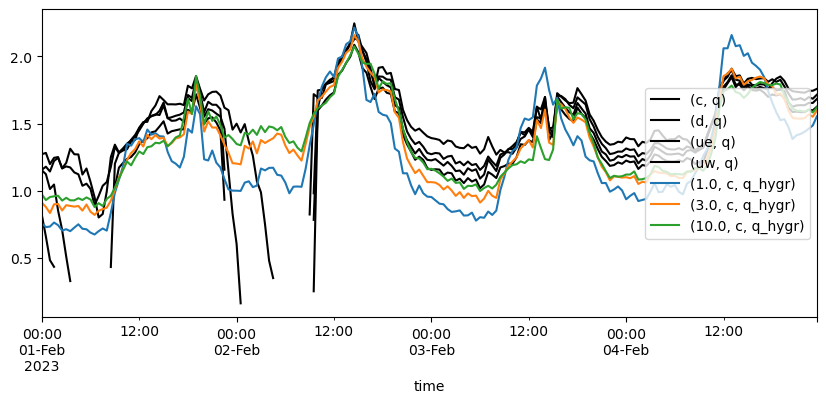

In [37]:


ax = abs_hum_field_df[3].loc['20230201': '20230204'].plot(figsize=(10,4), color='black', legend=False)
(1000*abs_hum_field_hygr_df.loc['20230201': '20230204']).plot(figsize=(10,4), ax=ax)
plt.legend(loc='right')

# 3D Differential Solution

## Calculate interpolated fields (3D)

In [38]:
HEIGHTS = [3,10]

# gather all measurements into a dataframe, isolate to the heights we care about
df = wind_field_df.join(
    turb_flux_field_df
).join(
    temp_turb_flux_field_df
).join(
    abs_hum_field_df
).join(
    adv_flux_field_df
).join(
    dryair_density_field_df
).join(
    temp_field_df
).join(
    mixing_ratio_field_df
)
data_df = df[HEIGHTS]

# Gather the instrument locations into a dataframe, isolate to heights we care about
instrument_loc_limited_heights = instrument_loc_df[instrument_loc_df.index.get_level_values(0).isin(HEIGHTS)]

# Transform the dataframe of instrument locations into a form that can be merged with the dataframe of measurements
#   transform
xxx = pd.DataFrame(instrument_loc_limited_heights.unstack().unstack()).T
xxx.columns = xxx.columns.swaplevel(0,2)
xxx.columns = xxx.columns.set_names('measurement', level=2)
#   duplicate the sensor locations so we can join (duplicate) x,y,z info into the dataframe of measurements
instrument_loc_limited_heights_repeated = xxx.loc[xxx.index.repeat(len(data_df))]
instrument_loc_limited_heights_repeated.index = data_df.index
instrument_loc_limited_heights_repeated
data_df = data_df.join(instrument_loc_limited_heights_repeated)

# Create a meshgrid for the interpolation and isolate the x,y,z locations of measurements
xx, yy, zz = np.meshgrid(
    np.linspace(instrument_loc_limited_heights.x.min(), instrument_loc_limited_heights.x.max(), HORIZ_GRID_SPACING),
    np.linspace(instrument_loc_limited_heights.y.min(), instrument_loc_limited_heights.y.max(), HORIZ_GRID_SPACING),
    np.linspace(instrument_loc_limited_heights.z.min(), instrument_loc_limited_heights.z.max(), VERT_GRID_SPACING)
)
spacing_x = np.diff(xx[0,:,0]).mean()
spacing_y = np.diff(yy[:,0,0]).mean()
spacing_z = np.diff(zz[0,0,:]).mean()
points = np.transpose(np.vstack((instrument_loc_limited_heights.x, instrument_loc_limited_heights.y, instrument_loc_limited_heights.z)))

# Calculate interpolated fields
    # VECTOR FIELDS
    # wind velocity fields
u_interp = data_df.loc[:, (slice(None),slice(None),['u'])].apply(
    lambda row:  interpolate.griddata(points, row.values, (xx, yy, zz), method='linear'),
    axis=1
)
v_interp = data_df.loc[:, (slice(None),slice(None),['v'])].apply(
    lambda row:  interpolate.griddata(points, row.values, (xx, yy, zz), method='linear'),
    axis=1
)
w_interp = data_df.loc[:, (slice(None),slice(None),['w'])].apply(
    lambda row:  interpolate.griddata(points, row.values, (xx, yy, zz), method='linear'),
    axis=1
)
    # turb. flux fields
u_q__interp = data_df.loc[:, (slice(None),slice(None),['u_h2o_'])].apply(
    lambda row:  interpolate.griddata(points, row.values, (xx, yy, zz), method='linear'),
    axis=1
)
v_q__interp = data_df.loc[:, (slice(None),slice(None),['v_h2o_'])].apply(
    lambda row:  interpolate.griddata(points, row.values, (xx, yy, zz), method='linear'),
    axis=1
)
w_q__interp = data_df.loc[:, (slice(None),slice(None),['w_h2o_'])].apply(
    lambda row:  interpolate.griddata(points, row.values, (xx, yy, zz), method='linear'),
    axis=1
)
    # SCALAR FIELDS
rho_interp = data_df.loc[:, (slice(None),slice(None),['rho'])].apply(
    lambda row:  interpolate.griddata(points, row.values, (xx, yy, zz), method='linear'),
    axis=1
)
r_interp = data_df.loc[:, (slice(None),slice(None),['r'])].apply(
    lambda row:  interpolate.griddata(points, row.values, (xx, yy, zz), method='linear'),
    axis=1
)
q_interp = data_df.loc[:, (slice(None),slice(None),['q'])].apply(
    lambda row:  interpolate.griddata(points, row.values, (xx, yy, zz), method='linear'),
    axis=1
)

### PLOT: Example of a 3d interpolated wind field

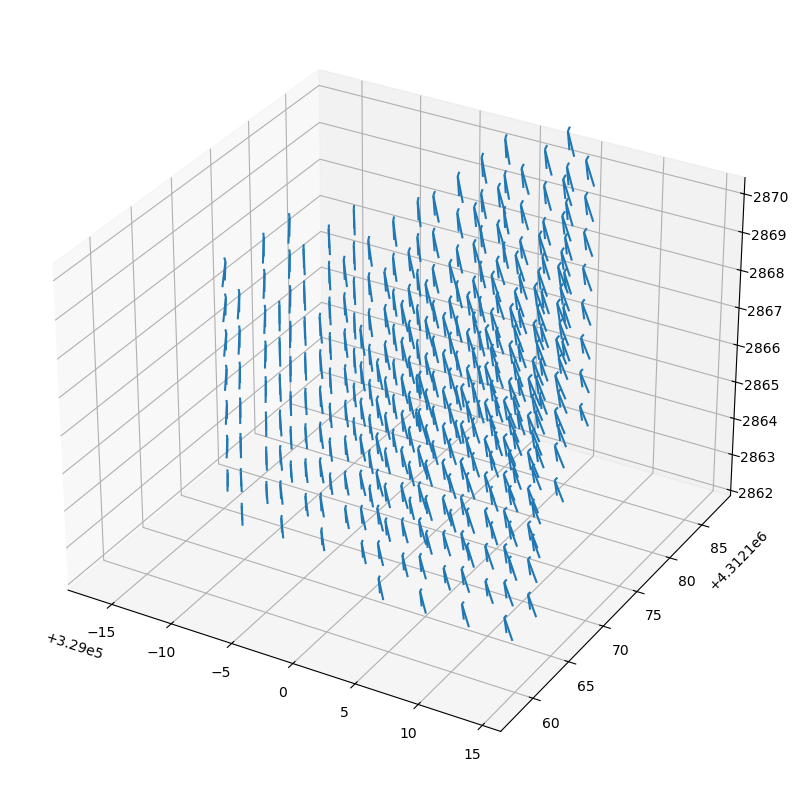

In [39]:

ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
ax.quiver(
    xx[::5,::5,::2], 
    yy[::5,::5,::2],
    zz[::5,::5,::2],
    u_interp[100][::5,::5,::2],
    v_interp[100][::5,::5,::2], 
    w_interp[100][::5,::5,::2],
    label='interpolated'
)
# plt.quiver(
#     data_df.iloc[100][(slice(None),slice(None),'x')].values.astype('float'),
#     data_df.iloc[100][(slice(None),slice(None),'y')].values.astype('float'),
#     data_df.iloc[100][(slice(None),slice(None),'z')].values.astype('float'),
#     data_df.iloc[100][(slice(None),slice(None),'u')].values.astype('float'),
#     data_df.iloc[100][(slice(None),slice(None),'v')].values.astype('float'),
#     data_df.iloc[100][(slice(None),slice(None),'w')].values.astype('float'),
#     label='measured',
#     color='red'
# )

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_82238/1647935838.py:1: RuntimeWarning: Mean of empty slice
  stable_mean_u_field = np.nanmean(np.stack(u_interp[u_interp.index.isin(ri_stable_times)].values), axis = 0)
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_82238/1647935838.py:2: RuntimeWarning: Mean of empty slice
  stable_mean_v_field = np.nanmean(np.stack(v_interp[v_interp.index.isin(ri_stable_times)].values), axis = 0)
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_82238/1647935838.py:3: RuntimeWarning: Mean of empty slice
  stable_mean_w_field = np.nanmean(np.stack(w_interp[w_interp.index.isin(ri_stable_times)].values), axis = 0)


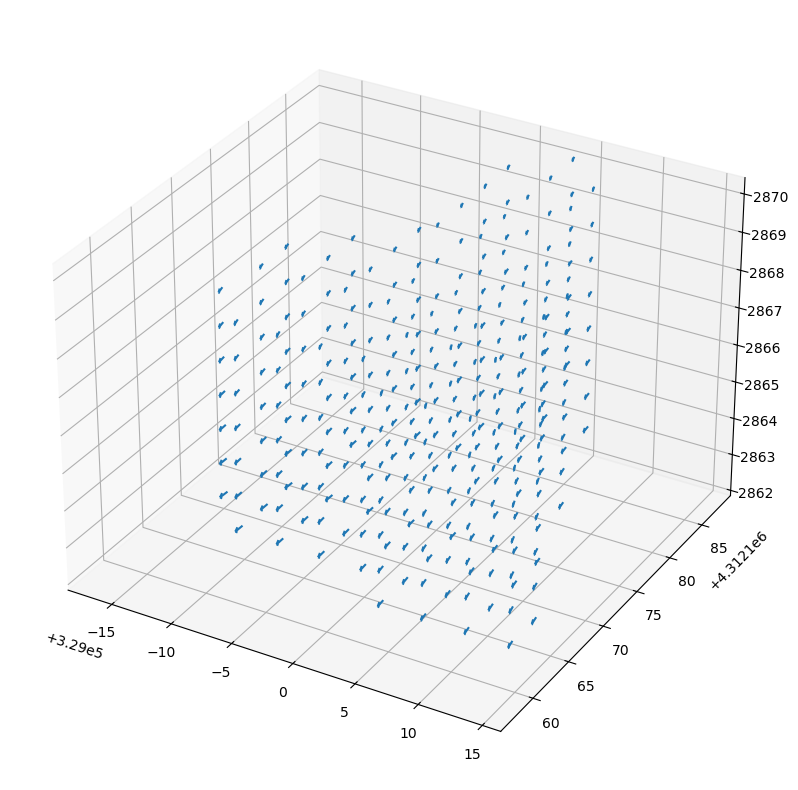

In [40]:
stable_mean_u_field = np.nanmean(np.stack(u_interp[u_interp.index.isin(ri_stable_times)].values), axis = 0)
stable_mean_v_field = np.nanmean(np.stack(v_interp[v_interp.index.isin(ri_stable_times)].values), axis = 0)
stable_mean_w_field = np.nanmean(np.stack(w_interp[w_interp.index.isin(ri_stable_times)].values), axis = 0)
# 3d plot
ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
ax.quiver(xx[::5,::5,::2],     yy[::5,::5,::2],    zz[::5,::5,::2], stable_mean_u_field[::5,::5,::2], stable_mean_v_field[::5,::5,::2],  stable_mean_w_field[::5,::5,::2],label='interpolated',)

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_82238/2941608932.py:5: RuntimeWarning: Mean of empty slice
  stable_mean_u_field = np.nanmean(np.stack(u_interp[u_interp.index.isin(ri_stable_times)].values), axis = 0)
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_82238/2941608932.py:6: RuntimeWarning: Mean of empty slice
  stable_mean_v_field = np.nanmean(np.stack(v_interp[v_interp.index.isin(ri_stable_times)].values), axis = 0)
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_82238/2941608932.py:7: RuntimeWarning: Mean of empty slice
  stable_mean_w_field = np.nanmean(np.stack(w_interp[w_interp.index.isin(ri_stable_times)].values), axis = 0)
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_82238/2941608932.py:19: RuntimeWarning: Mean of empty slice
  unstable_mean_u_field = np.nanmean(np.stack(u_interp[u_interp.index.isin(ri_unstable_times)].values), axis = 0)
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_82238/2941608932.py:20: 

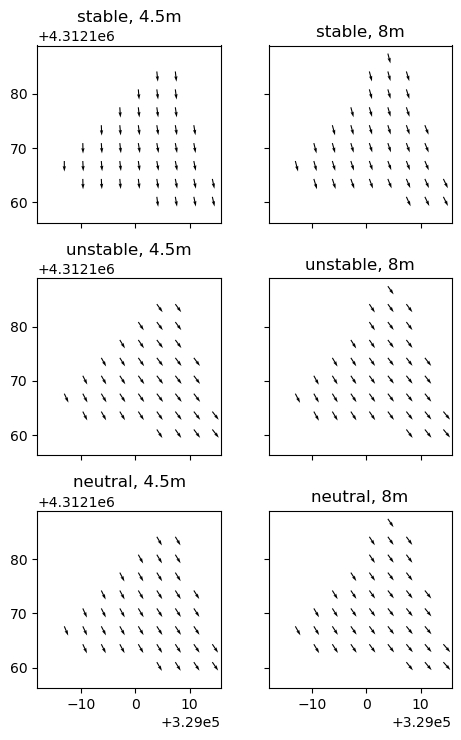

In [41]:
fig, axes = plt.subplots(3,2, figsize=(5,7.5), sharex=True, sharey=True)
for ax in axes.flatten():
    ax.set_aspect('equal')

stable_mean_u_field = np.nanmean(np.stack(u_interp[u_interp.index.isin(ri_stable_times)].values), axis = 0)
stable_mean_v_field = np.nanmean(np.stack(v_interp[v_interp.index.isin(ri_stable_times)].values), axis = 0)
stable_mean_w_field = np.nanmean(np.stack(w_interp[w_interp.index.isin(ri_stable_times)].values), axis = 0)
axes[0,0].quiver(
    xx[::5,::5,4],  yy[::5,::5,4],
    stable_mean_u_field[::5,::5,4], stable_mean_v_field[::5,::5,4], 
)
axes[0,0].set_title('stable, 4.5m')
axes[0,1].quiver(
    xx[::5,::5,15],  yy[::5,::5,15],
    stable_mean_u_field[::5,::5,15], stable_mean_v_field[::5,::5,15], 
)
axes[0,1].set_title('stable, 8m')

unstable_mean_u_field = np.nanmean(np.stack(u_interp[u_interp.index.isin(ri_unstable_times)].values), axis = 0)
unstable_mean_v_field = np.nanmean(np.stack(v_interp[v_interp.index.isin(ri_unstable_times)].values), axis = 0)
unstable_mean_w_field = np.nanmean(np.stack(w_interp[w_interp.index.isin(ri_unstable_times)].values), axis = 0)
axes[1,0].quiver(
    xx[::5,::5,4],  yy[::5,::5,4],
    unstable_mean_u_field[::5,::5,4], unstable_mean_v_field[::5,::5,4], 
)
axes[1,0].set_title('unstable, 4.5m')
axes[1,1].quiver(
    xx[::5,::5,15],  yy[::5,::5,15],
    unstable_mean_u_field[::5,::5,15], unstable_mean_v_field[::5,::5,15], 
)
axes[1,1].set_title('unstable, 8m')

neutral_mean_u_field = np.nanmean(np.stack(u_interp[u_interp.index.isin(ri_neutral_times)].values), axis = 0)
neutral_mean_v_field = np.nanmean(np.stack(v_interp[v_interp.index.isin(ri_neutral_times)].values), axis = 0)
neutral_mean_w_field = np.nanmean(np.stack(w_interp[w_interp.index.isin(ri_neutral_times)].values), axis = 0)
axes[2,0].quiver(
    xx[::5,::5,4],  yy[::5,::5,4],
    neutral_mean_u_field[::5,::5,4], neutral_mean_v_field[::5,::5,4], 
)
axes[2,0].set_title('neutral, 4.5m')
axes[2,1].quiver(
    xx[::5,::5,15],  yy[::5,::5,15],
    neutral_mean_u_field[::5,::5,15], neutral_mean_v_field[::5,::5,15], 
)
axes[2,1].set_title('neutral, 8m')
plt.tight_layout()

In [42]:
src_unstable = tidy_df[tidy_df.variable.isin(['w_h2o__3m_c', 'w_h2o__20m_c'])]
src_unstable = src_unstable[(src_unstable.time >= '20221130') & (src_unstable.time < '20230509')]
src_unstable = src_unstable[src_unstable.time.isin(set(ri_unstable_times).intersection(set(nobs_times)))]
src_unstable = src_unstable.pivot_table(index='time', values='value', columns='variable')
src_unstable['diff_unstable'] = src_unstable['w_h2o__20m_c'] - src_unstable['w_h2o__3m_c']

src_stable = tidy_df[tidy_df.variable.isin(['w_h2o__3m_c', 'w_h2o__20m_c'])]
src_stable = src_stable[(src_stable.time >= '20221130') & (src_stable.time < '20230509')]
src_stable = src_stable[src_stable.time.isin(set(ri_stable_times).intersection(set(nobs_times)))]
src_stable = src_stable.pivot_table(index='time', values='value', columns='variable')
src_stable['diff_stable'] = src_stable['w_h2o__20m_c'] - src_stable['w_h2o__3m_c']

src_neutral = tidy_df[tidy_df.variable.isin(['w_h2o__3m_c', 'w_h2o__20m_c'])]
src_neutral = src_neutral[(src_neutral.time >= '20221130') & (src_neutral.time < '20230509')]
src_neutral = src_neutral[src_neutral.time.isin(set(ri_neutral_times).intersection(set(nobs_times)))]
src_neutral = src_neutral.pivot_table(index='time', values='value', columns='variable')
src_neutral['diff_neutral'] = src_neutral['w_h2o__20m_c'] - src_neutral['w_h2o__3m_c']

src = pd.concat([
    src_neutral[['diff_neutral']].reset_index(),
    src_stable[['diff_stable']].reset_index(),
    src_unstable[['diff_unstable']].reset_index(),
])
alt.Chart(
    src.reset_index()
    # src.reset_index()
).transform_fold([
    'diff_neutral', 'diff_stable', 'diff_unstable'
]).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q'),
    alt.Color('key:N')
).properties(width=150, height=150)

alt.Chart(...)

In [43]:
src_unstable = tidy_df[tidy_df.variable.isin(['w_h2o__3m_c', 'w_h2o__20m_c'])]
src_unstable = src_unstable[(src_unstable.time >= '20221130') & (src_unstable.time < '20230509')]
src_unstable = src_unstable[src_unstable.time.isin(set(ri_unstable_times).intersection(set(nobs_times)))]
src_unstable = src_unstable.pivot_table(index='time', values='value', columns='variable')
src_unstable = src_unstable.reset_index()

src_stable = tidy_df[tidy_df.variable.isin(['w_h2o__3m_c', 'w_h2o__20m_c'])]
src_stable = src_stable[(src_stable.time >= '20221130') & (src_stable.time < '20230509')]
src_stable = src_stable[src_stable.time.isin(set(ri_stable_times).intersection(set(nobs_times)))]
src_stable = src_stable.pivot_table(index='time', values='value', columns='variable')
src_stable = src_stable.reset_index()

src_neutral = tidy_df[tidy_df.variable.isin(['w_h2o__3m_c', 'w_h2o__20m_c'])]
src_neutral = src_neutral[(src_neutral.time >= '20221130') & (src_neutral.time < '20230509')]
src_neutral = src_neutral[src_neutral.time.isin(set(ri_neutral_times).intersection(set(nobs_times)))]
src_neutral = src_neutral.pivot_table(index='time', values='value', columns='variable')
src_neutral = src_neutral.reset_index()

chart = alt.Chart(
).transform_fold([
    'w_h2o__3m_c', 'w_h2o__20m_c'
]).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q'),
    alt.Color('key:N')
)

alt.layer(
    chart,
    data =  src_stable[(src_stable.time >= '20221130') & (src_stable.time < '20230509')].reset_index()
) | alt.layer(
    chart,
    data =  src_neutral[(src_neutral.time >= '20221130') & (src_neutral.time < '20230509')].reset_index()
) | alt.layer(
    chart,
    data =  src_unstable[(src_unstable.time >= '20221130') & (src_unstable.time < '20230509')].reset_index()
)



alt.HConcatChart(...)

In [44]:
src_unstable = tidy_df[tidy_df.variable.isin(['w_h2o__3m_c', 'w_h2o__20m_c'])]
src_unstable = src_unstable[src_unstable.time.isin(set(ri_unstable_times).intersection(set(nobs_times)))]
src_unstable = src_unstable.pivot_table(index='time', values='value', columns='variable')
src_unstable['diff_unstable'] = src_unstable['w_h2o__20m_c'] - src_unstable['w_h2o__3m_c']

src_stable = tidy_df[tidy_df.variable.isin(['w_h2o__3m_c', 'w_h2o__20m_c'])]
src_stable = src_stable[src_stable.time.isin(set(ri_stable_times).intersection(set(nobs_times)))]
src_stable = src_stable.pivot_table(index='time', values='value', columns='variable')
src_stable['diff_stable'] = src_stable['w_h2o__20m_c'] - src_stable['w_h2o__3m_c']

src_neutral = tidy_df[tidy_df.variable.isin(['w_h2o__3m_c', 'w_h2o__20m_c'])]
src_neutral = src_neutral[src_neutral.time.isin(set(ri_neutral_times).intersection(set(nobs_times)))]
src_neutral = src_neutral.pivot_table(index='time', values='value', columns='variable')
src_neutral['diff_neutral'] = src_neutral['w_h2o__20m_c'] - src_neutral['w_h2o__3m_c']

src = pd.concat([
    src_neutral[['diff_neutral']].reset_index(),
    src_stable[['diff_stable']].reset_index(),
    src_unstable[['diff_unstable']].reset_index(),
])
alt.Chart(
    src[(src.time >= '20221130') & (src.time < '20230509')].reset_index()
    # src.reset_index()
).transform_fold([
    'diff_neutral', 'diff_stable', 'diff_unstable'
]).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q'),
    alt.Color('key:N')
)

alt.Chart(...)

In [45]:
src = tidy_df.query("measurement == 'wind direction'")
src = src[src.time.isin(ri_unstable_times)]
src
alt.Chart(src).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q'),
    alt.Color('height:O').scale(scheme='turbo'),
    alt.Facet('tower:N')
)

alt.Chart(...)

## Calculate terms (3D)

Calculate advective terms in both the Paw U form

$u \rho \dfrac{\partial s}{\partial x} + v \rho \dfrac{\partial s}{\partial y} + w \rho \dfrac{\partial s}{\partial z}$

and in the Sun form

$u \dfrac{\partial q}{\partial x} + v \dfrac{\partial q}{\partial y} + w \dfrac{\partial q}{\partial z}$

and also calculate the turbulent flux divergence terms (same for Paw U and Sun)

$\dfrac{\partial \overline{u'q'}}{\partial x} + \dfrac{\partial \overline{v'q'}}{\partial y} + \dfrac{\partial \overline{w'q'}}{\partial z}$

In [46]:
# Create dataframe with grids of interpolated data
u_interp.name = 'u'
v_interp.name = 'v'
w_interp.name = 'w'
u_q__interp.name = 'u_q_'
v_q__interp.name = 'v_q_'
w_q__interp.name = 'w_q_'
rho_interp.name = 'rho'
r_interp.name = 'r'
q_interp.name = 'q'

fields_df = pd.DataFrame(u_interp).join(
    v_interp
).join(
    w_interp
).join(
    u_q__interp
).join(
    v_q__interp
).join(
    w_q__interp
).join(
    rho_interp
).join(
    r_interp
).join(
    q_interp
)

In [47]:
# Iterate over the time series of fields and calculate the terms 
# We take the median of the gridded values.
# The apply function returns a tuple of 4 values, with each tuple contains values 
# for the following in order:
# means of:  lateral_advection_pawu , vertical_advection_pawu ,  lateral_advection_sun , vertical_advection_sun, lateral_turb_flux_div, vertical_turb_flux_div 
# medians of:  lateral_advection_pawu , vertical_advection_pawu ,  lateral_advection_sun , vertical_advection_sun, lateral_turb_flux_div, vertical_turb_flux_div 
advective_terms_3d = fields_df.apply(
    lambda row: 
    (
        # Lateral advection Paw U style
        np.nanmean(
            row['u']*row['rho']*np.gradient(row['r'], spacing_x, axis=0)
            +
            row['v']*row['rho']*np.gradient(row['r'], spacing_y, axis=1)
        ),
        # Vertical advection Paw U style
        np.nanmean(row['w']*row['rho']*np.gradient(row['r'], spacing_z, axis=2)),
        # Lateral advection Sun style
        np.nanmean(
            row['u']*np.gradient(row['q'], spacing_x, axis=0)
            +
            row['v']*np.gradient(row['q'], spacing_y, axis=1)
        ),
        # Vertical advection Sun style
        np.nanmean(row['w']*np.gradient(row['q'], spacing_z, axis=2)),
        # Lateral turb. flux divergence
        np.nanmean(
            np.gradient(row['u_q_'], spacing_x, axis=0)
            +
            np.gradient(row['v_q_'], spacing_y, axis=1)
        ),
        # Vertical turb. flux divergence
        np.nanmean(np.gradient(row['w_q_'], spacing_z, axis=2)),
        # Vertical air density flux term (Paw U only)
        ###???
        # Lateral advection Paw U style
        np.nanmedian(
            row['u']*row['rho']*np.gradient(row['r'], spacing_x, axis=0)
            +
            row['v']*row['rho']*np.gradient(row['r'], spacing_y, axis=1)
        ),
        # Vertical advection Paw U style
        np.nanmedian(row['w']*row['rho']*np.gradient(row['r'], spacing_z, axis=2)),
        # Lateral advection Sun style
        np.nanmedian(
            row['u']*np.gradient(row['q'], spacing_x, axis=0)
            +
            row['v']*np.gradient(row['q'], spacing_y, axis=1)
        ),
        # Vertical advection Sun style
        np.nanmedian(row['w']*np.gradient(row['q'], spacing_z, axis=2)),
        # Lateral turb. flux divergence
        np.nanmedian(
            np.gradient(row['u_q_'], spacing_x, axis=0)
            +
            np.gradient(row['v_q_'], spacing_y, axis=1)
        ),
        # Vertical turb. flux divergence
        np.nanmedian(np.gradient(row['w_q_'], spacing_z, axis=2)),
        # Vertical air density flux term (Paw U only)
        ###???
    )
    ,
    axis = 1
)
advective_terms_3d = pd.DataFrame(
    [[a, b, c, d, e, f, g, h, i, j, k, l] for a,b,c,d,e,f,g,h,i,j,k,l in advective_terms_3d.values], 
    columns=[
        'lateral_advection_pawu (mean)',
        'vertical_advection_pawu (mean)',
        'lateral_advection_sun (mean)',
        'vertical_advection_sun (mean)',
        'lateral_turb_flux_div (mean)',
        'vertical_turb_flux_div (mean)',
        
        'lateral_advection_pawu (median)',
        'vertical_advection_pawu (median)',
        'lateral_advection_sun (median)',
        'vertical_advection_sun (median)',
        'lateral_turb_flux_div (median)',
        'vertical_turb_flux_div (median)',
    ]
)
advective_terms_3d.index = fields_df.index

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_82238/2811015507.py:11: RuntimeWarning: Mean of empty slice
  np.nanmean(
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_82238/2811015507.py:17: RuntimeWarning: Mean of empty slice
  np.nanmean(row['w']*row['rho']*np.gradient(row['r'], spacing_z, axis=2)),
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_82238/2811015507.py:19: RuntimeWarning: Mean of empty slice
  np.nanmean(
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_82238/2811015507.py:25: RuntimeWarning: Mean of empty slice
  np.nanmean(row['w']*np.gradient(row['q'], spacing_z, axis=2)),
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_82238/2811015507.py:37: RuntimeWarning: All-NaN slice encountered
  np.nanmedian(
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_82238/2811015507.py:43: RuntimeWarning: All-NaN slice encountered
  np.nanmedian(row['w']*row['rho']*np.gradient(row['r'], spacing_z, axis=2)),
/var/folder

In [48]:
advective_terms_3d = advective_terms_3d*7
advective_terms_3d

,lateral_advection_pawu (mean),vertical_advection_pawu (mean),lateral_advection_sun (mean),vertical_advection_sun (mean),lateral_turb_flux_div (mean),vertical_turb_flux_div (mean),lateral_advection_pawu (median),vertical_advection_pawu (median),lateral_advection_sun (median),vertical_advection_sun (median),lateral_turb_flux_div (median),vertical_turb_flux_div (median)
time,,,,,,,,,,,,
2022-11-30 00:00:00,0.064367,0.002038,0.064959,0.001855,-0.002524,0.000739,0.218548,0.002042,0.220302,0.001918,-0.003335,0.000967
2022-11-30 00:30:00,0.042453,0.001751,0.042395,0.001629,-0.002024,0.000815,-0.000025,0.002561,-0.000270,0.002500,-0.002038,0.000782
2022-11-30 01:00:00,0.030272,0.001996,0.030334,0.001907,-0.000317,-0.000097,0.068065,0.002539,0.068322,0.002484,-0.000097,-0.000097
2022-11-30 01:30:00,0.054861,0.000734,0.055121,0.000742,-0.000367,0.000320,0.140996,0.000318,0.141964,0.000320,-0.000360,0.000136
2022-11-30 02:00:00,0.045092,0.004647,0.045043,0.004488,-0.001418,0.000416,0.006413,0.004286,0.006243,0.004175,0.002467,-0.000023
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-08 21:30:00,-0.011874,-0.001413,-0.009010,-0.001565,-0.000422,-0.002374,0.024188,-0.000994,0.027850,-0.001123,0.000569,-0.001994
2023-06-08 22:00:00,-0.023870,-0.009298,-0.020829,-0.010301,0.003450,-0.001433,0.009877,-0.007397,0.013425,-0.008347,0.004830,-0.001275
2023-06-08 22:30:00,-0.033848,-0.002666,-0.030870,-0.002999,0.003585,-0.000947,0.019005,-0.002587,0.022396,-0.002907,0.003323,-0.000823


## Calculate vertical velocity from horizontal divergence.

Following Vickers and Mahrt (2006), for incompressible mass continuity, time averaged vertical velocity based on divergence in 

$$ w(h) = - \int_{z=0}^{z=h} (\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y}) dz$$

In [98]:
def get_w_for_row(row):
    data = - np.nansum(
        (
            np.gradient(row['u'], spacing_x, axis=0)
            + np.gradient(row['v'], spacing_y, axis=1)
        ),
        axis = 2
    ) * (
        instrument_loc_limited_heights.z.max() 
        - instrument_loc_limited_heights.z.min()
    )

    data[data == 0] = np.nan
    data
    return np.nanmedian(data)

w_from_div = fields_df.apply(get_w_for_row, axis = 1)

alt.Chart(pd.DataFrame(w_from_div.rename('w')).reset_index()).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(w):Q')
)

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_82238/2380603603.py:15: RuntimeWarning: All-NaN slice encountered
  return np.nanmedian(data)


alt.Chart(...)

## Examine results

In [ ]:
mean_chart = (alt.Chart(
    (advective_terms_3d/7).reset_index()
).transform_fold(
    [c for c in list(advective_terms_3d.columns) if 'turb' not in c and 'mean' in c]
).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q'),
    alt.Color('key:N')
).properties(width=200, height = 150) | alt.Chart(
    advective_terms_3d.reset_index()
).transform_fold(
    [c for c in list(advective_terms_3d.columns) if 'turb' in c and 'mean' in c]
).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q'),
    alt.Color('key:N')
).properties(width=200, height = 150)).resolve_scale(color='independent')

median_chart = (alt.Chart(
    (advective_terms_3d/7).reset_index()
).transform_fold(
    [c for c in list(advective_terms_3d.columns) if 'turb' not in c and 'median' in c]
).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q'),
    alt.Color('key:N')
).properties(width=200, height = 150) | alt.Chart(
    advective_terms_3d.reset_index()
).transform_fold(
    [c for c in list(advective_terms_3d.columns) if 'turb' in c and 'median' in c]
).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q'),
    alt.Color('key:N')
).properties(width=200, height = 150)).resolve_scale(color='independent')

(mean_chart & median_chart).resolve_scale(y='shared', x='shared')

In [ ]:
alt.Chart(
    advective_terms_3d.loc['20230201': '20230205'].reset_index()
).transform_fold(
    list(advective_terms_3d.columns)
).mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q'),
    # .scale(domain=[0,0.02], clamp=True),
    alt.Color('key:N')
)

# 2D Differential Solution

## 3m height

Repeat all the steps we did above, but just for a single plane at 3m

In [ ]:
HEIGHTS_2D = [3]

# gather all measurements into a dataframe, isolate to the heights we care about
df = wind_field_df.join(
    turb_flux_field_df
).join(
    temp_turb_flux_field_df
).join(
    abs_hum_field_df
).join(
    adv_flux_field_df
).join(
    dryair_density_field_df
).join(
    temp_field_df
).join(
    mixing_ratio_field_df
)
data_df_2d = df[HEIGHTS_2D]

# Gather the instrument locations into a dataframe, isolate to heights we care about
instrument_loc_limited_heights_2d = instrument_loc_df[instrument_loc_df.index.get_level_values(0).isin(HEIGHTS_2D)]

# Transform the dataframe of instrument locations into a form that can be merged with the dataframe of measurements
#   transform
xxx = pd.DataFrame(instrument_loc_limited_heights_2d.unstack().unstack()).T
xxx.columns = xxx.columns.swaplevel(0,2)
xxx.columns = xxx.columns.set_names('measurement', level=2)
#   duplicate the sensor locations so we can join (duplicate) x,y,z info into the dataframe of measurements
instrument_loc_limited_heights_2d_repeated = xxx.loc[xxx.index.repeat(len(data_df_2d))]
instrument_loc_limited_heights_2d_repeated.index = data_df_2d.index
instrument_loc_limited_heights_2d_repeated
data_df_2d = data_df_2d.join(instrument_loc_limited_heights_2d_repeated)
data_df_2d

# Create a meshgrid for the interpolation and isolate the x,y,z locations of measurements
xx_2d, yy_2d = np.meshgrid(
    np.linspace(instrument_loc_limited_heights_2d.x.min(), instrument_loc_limited_heights_2d.x.max(), HORIZ_GRID_SPACING),
    np.linspace(instrument_loc_limited_heights_2d.y.min(), instrument_loc_limited_heights_2d.y.max(), HORIZ_GRID_SPACING)
)
spacing_x_2d = np.diff(xx_2d[0,:]).mean()
spacing_y_2d = np.diff(yy_2d[:,0]).mean()
points_2d = np.transpose(np.vstack((instrument_loc_limited_heights_2d.x, instrument_loc_limited_heights_2d.y)))

# Calculate interpolated fields
    # VECTOR FIELDS
    # wind velocity fields
u_interp_2d = data_df_2d.loc[:, (slice(None),slice(None),['u'])].apply(
    lambda row:  interpolate.griddata(points_2d, row.values, (xx_2d, yy_2d), method='linear'),
    axis=1
)
v_interp_2d = data_df_2d.loc[:, (slice(None),slice(None),['v'])].apply(
    lambda row:  interpolate.griddata(points_2d, row.values, (xx_2d, yy_2d), method='linear'),
    axis=1
)
w_interp_2d = data_df_2d.loc[:, (slice(None),slice(None),['w'])].apply(
    lambda row:  interpolate.griddata(points_2d, row.values, (xx_2d, yy_2d), method='linear'),
    axis=1
)
    # turb. flux fields
u_q__interp_2d = data_df_2d.loc[:, (slice(None),slice(None),['u_h2o_'])].apply(
    lambda row:  interpolate.griddata(points_2d, row.values, (xx_2d, yy_2d), method='linear'),
    axis=1
)
v_q__interp_2d = data_df_2d.loc[:, (slice(None),slice(None),['v_h2o_'])].apply(
    lambda row:  interpolate.griddata(points_2d, row.values, (xx_2d, yy_2d), method='linear'),
    axis=1
)
w_q__interp_2d = data_df_2d.loc[:, (slice(None),slice(None),['w_h2o_'])].apply(
    lambda row:  interpolate.griddata(points_2d, row.values, (xx_2d, yy_2d), method='linear'),
    axis=1
)
    # SCALAR FIELDS
rho_interp_2d = data_df_2d.loc[:, (slice(None),slice(None),['rho'])].apply(
    lambda row:  interpolate.griddata(points_2d, row.values, (xx_2d, yy_2d), method='linear'),
    axis=1
)
r_interp_2d = data_df_2d.loc[:, (slice(None),slice(None),['r'])].apply(
    lambda row:  interpolate.griddata(points_2d, row.values, (xx_2d, yy_2d), method='linear'),
    axis=1
)
q_interp_2d = data_df_2d.loc[:, (slice(None),slice(None),['q'])].apply(
    lambda row:  interpolate.griddata(points_2d, row.values, (xx_2d, yy_2d), method='linear'),
    axis=1
)

# Create dataframe with grids of interpolated data
u_interp_2d.name = 'u'
v_interp_2d.name = 'v'
w_interp_2d.name = 'w'
u_q__interp_2d.name = 'u_q_'
v_q__interp_2d.name = 'v_q_'
w_q__interp_2d.name = 'w_q_'
rho_interp_2d.name = 'rho'
r_interp_2d.name = 'r'
q_interp_2d.name = 'q'

fields_df_2d = pd.DataFrame(u_interp_2d).join(
    v_interp_2d
).join(
    w_interp_2d
).join(
    u_q__interp_2d
).join(
    v_q__interp_2d
).join(
    w_q__interp_2d
).join(
    rho_interp_2d
).join(
    r_interp_2d
).join(
    q_interp_2d
)

# Iterate over the time series of fields and calculate the terms 
# We take the median of the gridded values.
# The apply function returns a tuple of 4 values, with each tuple contains values 
# for the following in order:
#  means of: lateral_advection_pawu , vertical_advection_pawu ,  lateral_advection_sun , vertical_advection_sun, lateral_turb_flux_div, vertical_turb_flux_div 
#  medians of: lateral_advection_pawu , vertical_advection_pawu ,  lateral_advection_sun , vertical_advection_sun, lateral_turb_flux_div, vertical_turb_flux_div 
advective_terms_2d_3m = fields_df_2d.apply(
    lambda row: 
    (
        # Lateral advection Paw U style
        np.nanmean(
            row['u']*row['rho']*np.gradient(row['r'], spacing_x_2d, axis=0)
            +
            row['v']*row['rho']*np.gradient(row['r'], spacing_y_2d, axis=1)
        ),
        # Lateral advection Sun style
        np.nanmean(
            row['u']*np.gradient(row['q'], spacing_x_2d, axis=0)
            +
            row['v']*np.gradient(row['q'], spacing_y_2d, axis=1)
        ),
        # Lateral turb. flux divergence
        np.nanmean(
            np.gradient(row['u_q_'], spacing_x_2d, axis=0)
            +
            np.gradient(row['v_q_'], spacing_y_2d, axis=1)
        ),
        # Lateral advection Paw U style
        np.nanmedian(
            row['u']*row['rho']*np.gradient(row['r'], spacing_x_2d, axis=0)
            +
            row['v']*row['rho']*np.gradient(row['r'], spacing_y_2d, axis=1)
        ),
        # Lateral advection Sun style
        np.nanmedian(
            row['u']*np.gradient(row['q'], spacing_x_2d, axis=0)
            +
            row['v']*np.gradient(row['q'], spacing_y_2d, axis=1)
        ),
        # Lateral turb. flux divergence
        np.nanmedian(
            np.gradient(row['u_q_'], spacing_x_2d, axis=0)
            +
            np.gradient(row['v_q_'], spacing_y_2d, axis=1)
        ),
    ),
    axis = 1
)
advective_terms_2d_3m = pd.DataFrame(
    [[a, b, c, d, e, f] for a, b, c, d, e, f in advective_terms_2d_3m.values], 
    columns=[
        'lateral_advection_pawu (mean)', 
        'lateral_advection_sun (mean)',
        'lateral_turb_flux_div (mean)', 
        'lateral_advection_pawu (median)', 
        'lateral_advection_sun (median)',
        'lateral_turb_flux_div (median)', 
    ]
)
advective_terms_2d_3m.index = fields_df_2d.index

### PLOT: Example of a 2d interpolated wind field

In [ ]:

plt.quiver(
    xx_2d[::4], 
    yy_2d[::4],
    u_interp_2d[100][::4],
    v_interp_2d[100][::4], 
    label='interpolated'
)
plt.quiver(
    data_df_2d.iloc[100][(slice(None),slice(None),'x')].values.astype('float'),
    data_df_2d.iloc[100][(slice(None),slice(None),'y')].values.astype('float'),
    data_df_2d.iloc[100][(slice(None),slice(None),'u')].values.astype('float'),
    data_df_2d.iloc[100][(slice(None),slice(None),'v')].values.astype('float'),
    label='measured',
    color='red'
)

## 10m height

Repeat all the steps we did above, but just for a single plane at 3m

In [ ]:
HEIGHTS_2D = [10]

# gather all measurements into a dataframe, isolate to the heights we care about
df = wind_field_df.join(
    turb_flux_field_df
).join(
    temp_turb_flux_field_df
).join(
    abs_hum_field_df
).join(
    adv_flux_field_df
).join(
    dryair_density_field_df
).join(
    temp_field_df
).join(
    mixing_ratio_field_df
)
data_df_2d = df[HEIGHTS_2D]

# Gather the instrument locations into a dataframe, isolate to heights we care about
instrument_loc_limited_heights_2d = instrument_loc_df[instrument_loc_df.index.get_level_values(0).isin(HEIGHTS_2D)]

# Transform the dataframe of instrument locations into a form that can be merged with the dataframe of measurements
#   transform
xxx = pd.DataFrame(instrument_loc_limited_heights_2d.unstack().unstack()).T
xxx.columns = xxx.columns.swaplevel(0,2)
xxx.columns = xxx.columns.set_names('measurement', level=2)
#   duplicate the sensor locations so we can join (duplicate) x,y,z info into the dataframe of measurements
instrument_loc_limited_heights_2d_repeated = xxx.loc[xxx.index.repeat(len(data_df_2d))]
instrument_loc_limited_heights_2d_repeated.index = data_df_2d.index
instrument_loc_limited_heights_2d_repeated
data_df_2d = data_df_2d.join(instrument_loc_limited_heights_2d_repeated)
data_df_2d

# Create a meshgrid for the interpolation and isolate the x,y,z locations of measurements
xx_2d, yy_2d = np.meshgrid(
    np.linspace(instrument_loc_limited_heights_2d.x.min(), instrument_loc_limited_heights_2d.x.max(), HORIZ_GRID_SPACING),
    np.linspace(instrument_loc_limited_heights_2d.y.min(), instrument_loc_limited_heights_2d.y.max(), HORIZ_GRID_SPACING)
)
spacing_x_2d = np.diff(xx_2d[0,:]).mean()
spacing_y_2d = np.diff(yy_2d[:,0]).mean()
points_2d = np.transpose(np.vstack((instrument_loc_limited_heights_2d.x, instrument_loc_limited_heights_2d.y)))

# Calculate interpolated fields
    # VECTOR FIELDS
    # wind velocity fields
u_interp_2d = data_df_2d.loc[:, (slice(None),slice(None),['u'])].apply(
    lambda row:  interpolate.griddata(points_2d, row.values, (xx_2d, yy_2d), method='linear'),
    axis=1
)
v_interp_2d = data_df_2d.loc[:, (slice(None),slice(None),['v'])].apply(
    lambda row:  interpolate.griddata(points_2d, row.values, (xx_2d, yy_2d), method='linear'),
    axis=1
)
w_interp_2d = data_df_2d.loc[:, (slice(None),slice(None),['w'])].apply(
    lambda row:  interpolate.griddata(points_2d, row.values, (xx_2d, yy_2d), method='linear'),
    axis=1
)
    # turb. flux fields
u_q__interp_2d = data_df_2d.loc[:, (slice(None),slice(None),['u_h2o_'])].apply(
    lambda row:  interpolate.griddata(points_2d, row.values, (xx_2d, yy_2d), method='linear'),
    axis=1
)
v_q__interp_2d = data_df_2d.loc[:, (slice(None),slice(None),['v_h2o_'])].apply(
    lambda row:  interpolate.griddata(points_2d, row.values, (xx_2d, yy_2d), method='linear'),
    axis=1
)
w_q__interp_2d = data_df_2d.loc[:, (slice(None),slice(None),['w_h2o_'])].apply(
    lambda row:  interpolate.griddata(points_2d, row.values, (xx_2d, yy_2d), method='linear'),
    axis=1
)
    # SCALAR FIELDS
rho_interp_2d = data_df_2d.loc[:, (slice(None),slice(None),['rho'])].apply(
    lambda row:  interpolate.griddata(points_2d, row.values, (xx_2d, yy_2d), method='linear'),
    axis=1
)
r_interp_2d = data_df_2d.loc[:, (slice(None),slice(None),['r'])].apply(
    lambda row:  interpolate.griddata(points_2d, row.values, (xx_2d, yy_2d), method='linear'),
    axis=1
)
q_interp_2d = data_df_2d.loc[:, (slice(None),slice(None),['q'])].apply(
    lambda row:  interpolate.griddata(points_2d, row.values, (xx_2d, yy_2d), method='linear'),
    axis=1
)

# Create dataframe with grids of interpolated data
u_interp_2d.name = 'u'
v_interp_2d.name = 'v'
w_interp_2d.name = 'w'
u_q__interp_2d.name = 'u_q_'
v_q__interp_2d.name = 'v_q_'
w_q__interp_2d.name = 'w_q_'
rho_interp_2d.name = 'rho'
r_interp_2d.name = 'r'
q_interp_2d.name = 'q'

fields_df_2d = pd.DataFrame(u_interp_2d).join(
    v_interp_2d
).join(
    w_interp_2d
).join(
    u_q__interp_2d
).join(
    v_q__interp_2d
).join(
    w_q__interp_2d
).join(
    rho_interp_2d
).join(
    r_interp_2d
).join(
    q_interp_2d
)

# Iterate over the time series of fields and calculate the terms 
# We take the median of the gridded values.
# The apply function returns a tuple of 4 values, with each tuple contains values 
# for the following in order:
#  lateral_advection_pawu , vertical_advection_pawu ,  lateral_advection_sun , vertical_advection_sun, lateral_turb_flux_div, vertical_turb_flux_div 
advective_terms_2d_10m = fields_df_2d.apply(
    lambda row: 
    (
        # Lateral advection Paw U style
        np.nanmean(
            row['u']*row['rho']*np.gradient(row['r'], spacing_x_2d, axis=0)
            +
            row['v']*row['rho']*np.gradient(row['r'], spacing_y_2d, axis=1)
        ),
        # Lateral advection Sun style
        np.nanmean(
            row['u']*np.gradient(row['q'], spacing_x_2d, axis=0)
            +
            row['v']*np.gradient(row['q'], spacing_y_2d, axis=1)
        ),
        # Lateral turb. flux divergence
        np.nanmean(
            np.gradient(row['u_q_'], spacing_x_2d, axis=0)
            +
            np.gradient(row['v_q_'], spacing_y_2d, axis=1)
        ),
        # Lateral advection Paw U style
        np.nanmedian(
            row['u']*row['rho']*np.gradient(row['r'], spacing_x_2d, axis=0)
            +
            row['v']*row['rho']*np.gradient(row['r'], spacing_y_2d, axis=1)
        ),
        # Lateral advection Sun style
        np.nanmedian(
            row['u']*np.gradient(row['q'], spacing_x_2d, axis=0)
            +
            row['v']*np.gradient(row['q'], spacing_y_2d, axis=1)
        ),
        # Lateral turb. flux divergence
        np.nanmedian(
            np.gradient(row['u_q_'], spacing_x_2d, axis=0)
            +
            np.gradient(row['v_q_'], spacing_y_2d, axis=1)
        ),
    ),
    axis = 1
)
advective_terms_2d_10m = pd.DataFrame(
    [[a, b, c, d, e, f] for a, b, c, d, e, f in advective_terms_2d_10m.values], 
    columns=[
        'lateral_advection_pawu (mean)', 
        'lateral_advection_sun (mean)',
        'lateral_turb_flux_div (mean)', 
        'lateral_advection_pawu (median)', 
        'lateral_advection_sun (median)',
        'lateral_turb_flux_div (median)', 
    ]
)
advective_terms_2d_10m.index = fields_df_2d.index

## Average the two planes

In [ ]:
advective_terms_2d_3m

In [ ]:
advective_terms_2d_10m

In [ ]:
advective_terms_2d = (advective_terms_2d_3m + advective_terms_2d_10m)/2
advective_terms_2d = advective_terms_2d*7

## Examine results

In [ ]:
alt.Chart(
    advective_terms_2d.reset_index()
).transform_fold(
    [c for c in list(advective_terms_2d.columns) if 'turb' not in c]
).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q'),
    alt.Color('key:N')
).properties(width=200, height = 150) | alt.Chart(
    advective_terms_2d.reset_index()
).transform_fold(
    [c for c in list(advective_terms_2d.columns) if 'turb' in c]
).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q'),
    alt.Color('key:N')
).properties(width=200, height = 150)

In [ ]:
alt.Chart(
    advective_terms_3d.reset_index()
).transform_fold(
    [c for c in list(advective_terms_3d.columns) if 'turb' not in c]
).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q'),
    alt.Color('key:N')
).properties(width=200, height = 150) | alt.Chart(
    advective_terms_3d.reset_index()
).transform_fold(
    [c for c in list(advective_terms_3d.columns) if 'turb' in c]
).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q'),
    alt.Color('key:N')
).properties(width=200, height = 150)

# Surface Integral Solution

## Define area of triangular prism faces

In [ ]:
from metpy.units import units

In [ ]:
# Define face areas
A1 = A2 = A3 = 37 * 7 * units('m^2')
A4 = A5 = 580.2 * units('m^2')
CV_HEIGHT = 7*units('m')
VOLUME = A4*CV_HEIGHT
A1, A2, A3, A4, A5, VOLUME

## Define normal vectors to the triangular prism faces

In [ ]:
# ELI'S angles
n1 = np.array([ np.cos(np.deg2rad(258.7)),   np.sin(np.deg2rad(258.7))])*units(None)
n2 = np.array([ np.cos(np.deg2rad(20.1)),   np.sin(np.deg2rad(20.1))])*units(None)
n3 = np.array([ np.cos(np.deg2rad(139.26)),   np.sin(np.deg2rad(139.26))])*units(None)

# DANNY'S angles
# n1 = np.array([ np.cos(np.deg2rad(269.5)),   np.sin(np.deg2rad(269.5))])*units(None)
# n2 = np.array([ np.cos(np.deg2rad(19.5)),   np.sin(np.deg2rad(19.5))])*units(None)
# n3 = np.array([ np.cos(np.deg2rad(143.5)),   np.sin(np.deg2rad(143.5))])*units(None)

In [ ]:
import geopandas as gpd
instrument_loc_df = gpd.GeoDataFrame(
    instrument_loc_df,
    geometry = gpd.points_from_xy(
        instrument_loc_df.x, 
        instrument_loc_df.y, 
        instrument_loc_df.z
    ),
    crs = 'EPSG:32613'
)
instrument_loc_df = instrument_loc_df.to_crs('EPSG:4326')
instrument_loc_df

## Calculate storage term

In [ ]:
storage_change_term = tidy_df[
    tidy_df.measurement.isin(['specific humidity', 'air density'])
].query("tower == 'c'").query("height <= 10").query("height >= 3").groupby(
    ['time', 'tower', 'measurement']
)[['value']].mean().reset_index() 
storage_change_term = storage_change_term.pivot_table(index='time', values='value', columns='measurement')

In [ ]:
timestep = storage_change_term.index.diff()[1].seconds * units('seconds')
print(timestep)
absolute_humidity = storage_change_term['specific humidity'].values * units("g/g")  * (
    storage_change_term['air density'].values * units("kg/m^3")
)
delta_humidity = np.diff(absolute_humidity * VOLUME, prepend=np.nan)
dq_dt = delta_humidity / timestep

In [ ]:
storage_change_term['absolute humidity (g/m^3)'] = absolute_humidity.to('g/m^3')
storage_change_term['delta water storage (g/s)'] = dq_dt.to('grams/second')

## Calculate advective flux

In [ ]:
advective_flux_3m_ue = wind_field_df[3]['ue'].multiply(
    abs_hum_field_df[3]['ue']['q'],
    axis=0
).rename(columns={'u': 'uq', 'v': 'vq','w': 'wq',})

advective_flux_10m_ue = wind_field_df[10]['ue'].multiply(
    abs_hum_field_df[10]['ue']['q'],
    axis=0
).rename(columns={'u': 'uq', 'v': 'vq','w': 'wq',})

advective_flux_3m_uw = wind_field_df[3]['uw'].multiply(
    abs_hum_field_df[3]['uw']['q'],
    axis=0
).rename(columns={'u': 'uq', 'v': 'vq','w': 'wq',})

advective_flux_10m_uw = wind_field_df[10]['uw'].multiply(
    abs_hum_field_df[10]['uw']['q'],
    axis=0
).rename(columns={'u': 'uq', 'v': 'vq','w': 'wq',})

advective_flux_3m_d = wind_field_df[3]['d'].multiply(
    abs_hum_field_df[3]['d']['q'],
    axis=0
).rename(columns={'u': 'uq', 'v': 'vq','w': 'wq',})

advective_flux_10m_d = wind_field_df[10]['d'].multiply(
    abs_hum_field_df[10]['d']['q'],
    axis=0
).rename(columns={'u': 'uq', 'v': 'vq','w': 'wq',})

advective_flux_3m_c = wind_field_df[3]['c'].multiply(
    abs_hum_field_df[3]['c']['q'],
    axis=0
).rename(columns={'u': 'uq', 'v': 'vq','w': 'wq',})

advective_flux_10m_c = wind_field_df[10]['c'].multiply(
    abs_hum_field_df[10]['c']['q'],
    axis=0
).rename(columns={'u': 'uq', 'v': 'vq','w': 'wq',})

In [ ]:
# Calculate the average u, v, and w components needed to calculate flux through each face
face1_avg_u_flux = 0.25*(
    advective_flux_3m_uw['uq'] + advective_flux_10m_uw['uq'] + 
    advective_flux_3m_d['uq'] + advective_flux_10m_d['uq']
)

face1_avg_v_flux = 0.25*(
    advective_flux_3m_uw['vq'] + advective_flux_10m_uw['vq'] + 
    advective_flux_3m_d['vq'] + advective_flux_10m_d['vq']
)

face2_avg_u_flux = 0.25*(
    advective_flux_3m_ue['uq'] + advective_flux_10m_ue['uq'] + 
    advective_flux_3m_d['uq'] + advective_flux_10m_d['uq']
)

face2_avg_v_flux = 0.25*(
    advective_flux_3m_ue['vq'] + advective_flux_10m_ue['vq'] + 
    advective_flux_3m_d['vq'] + advective_flux_10m_d['vq']
)

face3_avg_u_flux = 0.25*(
    advective_flux_3m_ue['uq'] + advective_flux_10m_ue['uq'] + 
    advective_flux_3m_uw['uq'] + advective_flux_10m_uw['uq']
)

face3_avg_v_flux = 0.25*(
    advective_flux_3m_ue['vq'] + advective_flux_10m_ue['vq'] + 
    advective_flux_3m_uw['vq'] + advective_flux_10m_uw['vq']
)

face4_avg_w_flux = 0.25*(
    advective_flux_10m_ue['wq'] + advective_flux_10m_uw['wq'] + 
    advective_flux_10m_c['wq'] + advective_flux_10m_d['wq']
)

face5_avg_w_flux = - 0.25*(
    advective_flux_3m_ue['wq'] + advective_flux_3m_uw['wq'] + 
    advective_flux_3m_c['wq'] + advective_flux_3m_d['wq']
)

# Combine the (separate) u and v components into a list of vectors for the lateral faces
face1_avg_adv_flux = np.array([
    face1_avg_u_flux,
    face1_avg_v_flux
]).T

face2_avg_adv_flux = np.array([
    face2_avg_u_flux,
    face2_avg_v_flux
]).T

face3_avg_adv_flux = np.array([
    face3_avg_u_flux,
    face3_avg_v_flux
]).T

# Project the lateral flux vectors onto the face-normal vectors
face1_projected_adv_flux = np.dot(face1_avg_adv_flux, n1.m)
face2_projected_adv_flux = np.dot(face2_avg_adv_flux, n2.m)
face3_projected_adv_flux = np.dot(face3_avg_adv_flux, n3.m)

# Calculate total lateral and vertical flux
total_lateral_adv_divergence = (
    face1_projected_adv_flux*A1.m + 
    face2_projected_adv_flux*A2.m + 
    face3_projected_adv_flux*A3.m
) / VOLUME.m

total_vertical_adv_divergence = (face4_avg_w_flux*A4 + face5_avg_w_flux*A5)  / VOLUME

## Calculate turbulent flux divergence

In [ ]:
# Calculate the average u, v, and w components needed to calculate flux through each face
face1_avg_u_turb_flux = 0.25*(
    turb_flux_field_df[3]['uw']['u_h2o_'] + turb_flux_field_df[10]['uw']['u_h2o_'] + 
    turb_flux_field_df[3]['d']['u_h2o_'] + turb_flux_field_df[10]['d']['u_h2o_']
)

face1_avg_v_turb_flux = 0.25*(
    turb_flux_field_df[3]['uw']['v_h2o_'] + turb_flux_field_df[10]['uw']['v_h2o_'] + 
    turb_flux_field_df[3]['d']['v_h2o_'] + turb_flux_field_df[10]['d']['v_h2o_']
)

face2_avg_u_turb_flux = 0.25*(
    turb_flux_field_df[3]['ue']['u_h2o_'] + turb_flux_field_df[10]['ue']['u_h2o_'] + 
    turb_flux_field_df[3]['d']['u_h2o_'] + turb_flux_field_df[10]['d']['u_h2o_']
)

face2_avg_v_turb_flux = 0.25*(
    turb_flux_field_df[3]['ue']['v_h2o_'] + turb_flux_field_df[10]['ue']['v_h2o_'] + 
    turb_flux_field_df[3]['d']['v_h2o_'] + turb_flux_field_df[10]['d']['v_h2o_']
)

face3_avg_u_turb_flux = 0.25*(
    turb_flux_field_df[3]['ue']['u_h2o_'] + turb_flux_field_df[10]['ue']['u_h2o_'] + 
    turb_flux_field_df[3]['uw']['u_h2o_'] + turb_flux_field_df[10]['uw']['u_h2o_']
)

face3_avg_v_turb_flux = 0.25*(
    turb_flux_field_df[3]['ue']['v_h2o_'] + turb_flux_field_df[10]['ue']['v_h2o_'] + 
    turb_flux_field_df[3]['uw']['v_h2o_'] + turb_flux_field_df[10]['uw']['v_h2o_']
)

face4_avg_w_turb_flux = 0.25*(
    turb_flux_field_df[10]['ue']['w_h2o_'] + turb_flux_field_df[10]['uw']['w_h2o_'] + 
    turb_flux_field_df[10]['c']['w_h2o_'] + turb_flux_field_df[10]['d']['w_h2o_']
)

face5_avg_w_turb_flux = - 0.25*(
    turb_flux_field_df[3]['ue']['w_h2o_'] + turb_flux_field_df[3]['uw']['w_h2o_'] + 
    turb_flux_field_df[3]['c']['w_h2o_'] + turb_flux_field_df[3]['d']['w_h2o_']
)

# Combine the (separate) u and v components into a list of vectors for the lateral faces
face1_avg_adv_flux = np.array([
    face1_avg_u_turb_flux,
    face1_avg_v_turb_flux
]).T

face2_avg_adv_flux = np.array([
    face2_avg_u_turb_flux,
    face2_avg_v_turb_flux
]).T

face3_avg_adv_flux = np.array([
    face3_avg_u_turb_flux,
    face3_avg_v_turb_flux
]).T

# Project the lateral flux vectors onto the face-normal vectors
face1_projected_turb_flux = np.dot(face1_avg_adv_flux, n1.m)
face2_projected_turb_flux = np.dot(face2_avg_adv_flux, n2.m)
face3_projected_turb_flux = np.dot(face3_avg_adv_flux, n3.m)

# Calculate total lateral and vertical flux
total_lateral_turb_divergence = (
    face1_projected_turb_flux*A1.m + 
    face2_projected_turb_flux*A2.m + 
    face3_projected_turb_flux*A3.m
) / VOLUME.m

total_vertical_turb_divergence = (face4_avg_w_turb_flux*A4 + face5_avg_w_turb_flux*A5)  / VOLUME

## Examine results

In [ ]:
((
    alt.Chart(
        pd.DataFrame(total_vertical_turb_divergence).reset_index()
    ).mark_line().encode(
        alt.X('hoursminutes(time):T'),
        alt.Y('median(w_h2o_):Q')
    )
).properties(title='Vertical Turb. Flux Divergence') | (
    alt.Chart(
        pd.DataFrame(total_lateral_turb_divergence).reset_index().assign(time=total_vertical_turb_divergence.index).rename(columns={0:'u_q_'})
    ).mark_line().encode(
        alt.X('hoursminutes(time):T'),
        alt.Y('median(u_q_):Q')
    )
).properties(title='Lateral Turb. Flux Divergence')).resolve_scale(y='shared', x='shared')

In [ ]:
((
    alt.Chart(
        pd.DataFrame(total_vertical_adv_divergence).reset_index()
    ).mark_line().encode(
        alt.X('hoursminutes(time):T'),
        alt.Y('mean(wq):Q')
    )
    +
    alt.Chart(
        pd.DataFrame(total_vertical_adv_divergence).reset_index()
    ).mark_line(color='red').encode(
        alt.X('hoursminutes(time):T'),
        alt.Y('median(wq):Q')
    )
).properties(title='Vertical Advection') | (
    alt.Chart(
        pd.DataFrame(total_lateral_adv_divergence).reset_index().assign(time=total_vertical_adv_divergence.index).rename(columns={0:'uq'})
    ).mark_line().encode(
        alt.X('hoursminutes(time):T'),
        alt.Y('mean(uq):Q')
    )
    +
    alt.Chart(
        pd.DataFrame(total_lateral_adv_divergence).reset_index().assign(time=total_vertical_adv_divergence.index).rename(columns={0:'uq'})
    ).mark_line(color='red').encode(
        alt.X('hoursminutes(time):T'),
        alt.Y('median(uq):Q')
    )
).properties(title='Lateral Advection')).resolve_scale(y='shared', x='shared')

# 1D Differential Solution

## Calculate horizontal advection (using two-point solution to derivative)

### Using KPS and Annex Hygrometer measurements

In [39]:
kps_snowdepth_df = tidy_df.query("variable == 'SnowDepth_c'").set_index('time')
annex_snowdepth_df = annex_snowdepth_ds.to_dataframe()#.loc[kps_snowdepth_df.index.min(), kps_snowdepth_df.index.max()]
annex_snowdepth_df = annex_snowdepth_df.resample('30min').median().loc[kps_snowdepth_df.index.min(): kps_snowdepth_df.index.max()]

In [40]:
kps_src = (tidy_df.query(
        "measurement == 'mixing ratio'"
    ).set_index('time').loc['20230201 1000': '20230201 1500'].query(
        "height > 0"
    )).reset_index()
kps_src['value'] = kps_src['value'] * 1000
alt.Chart(
    kps_src.query("height <= 5")
).mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q').scale(zero=False),
    alt.Color('height:O')
) +\
alt.Chart(
mixingratio_ds.to_dataframe().sort_index().loc['20230201 1000': '20230201 1500'].resample('30min').mean().reset_index()
).mark_line(color='red').encode(
    alt.X('time:T'),
    alt.Y('mixing_ratio:Q').scale(zero=False)
)

alt.LayerChart(...)

In [41]:
snowdepth_pair = pd.DataFrame(annex_snowdepth_df['snow_depth'].rename('annex')).join(
    (100*kps_snowdepth_df['value'].rename('kps'))
).reset_index()

onetoone_line = alt.Chart(pd.DataFrame({'x':[0, 200], 'y':[0, 200]})).mark_line(color='grey').encode(x='x', y='y')
(alt.Chart(snowdepth_pair).mark_line().transform_fold([
    'annex', 'kps'
]).mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q'),
    alt.Color('key:N')
) | onetoone_line+alt.Chart(snowdepth_pair.set_index('time').resample('1440min').mean().reset_index()).mark_circle().encode(
    alt.X('annex:Q'),
    alt.Y('kps:Q')
)).configure_legend(orient='top')

alt.HConcatChart(...)

In [42]:
# Calculate horizontal advection 
# combine mixing ratio measurements from the two sites into one dataframe 
kpsannex_mixingratio_measurements = mixingratio_ds.sortby('time').sel(
    time=slice(data_start_date, data_cutoff_date)
).resample(time='30min').mean().rename('annex').to_dataframe() / 1000
# kps_mixingratio_measurements = abs_hum_field_hygr_df[3]['c']['q_hygr'].rename('kps')
kps_mixingratio_measurements_2m = tidy_df.query("variable == 'mixingratio_2m_c'").set_index('time')['value'].rename('kps_2m')
kps_mixingratio_measurements_3m = tidy_df.query("variable == 'mixingratio_3m_c'").set_index('time')['value'].rename('kps_3m')
kps_mixingratio_measurements_4m = tidy_df.query("variable == 'mixingratio_4m_c'").set_index('time')['value'].rename('kps_4m')

kps_lateral_simple_df = kpsannex_mixingratio_measurements.join(
    kps_mixingratio_measurements_2m
).join(
    kps_mixingratio_measurements_3m
).join(
    kps_mixingratio_measurements_4m
)

# isolate measurements to when wind is up (100˚ - 140˚) or downvalley (300 - 340)
kps_lateral_simple_df = kps_lateral_simple_df.join(
    tidy_df.query("variable == 'dir_10m_c'").set_index('time')['value'].rename('dir_10m_c')
).join(
    tidy_df.query("variable == 'spd_3m_c'").set_index('time')['value'].rename('spd_3m_c')
).join(
    1000*tidy_df.query("variable == 'dryairdensity_3m_c'").set_index('time')['value'].rename('rho')
).join(
    tidy_df.query("variable == 'w_h2o__3m_c'").set_index('time')['value'].rename('w_h2o__3m_c')
)

kps_lateral_simple_df = kps_lateral_simple_df[
    ((kps_lateral_simple_df.dir_10m_c >= 112) & (kps_lateral_simple_df.dir_10m_c <= 152))
    |
    ((kps_lateral_simple_df.dir_10m_c >= 292) & (kps_lateral_simple_df.dir_10m_c <= 332))
]
# label each timestamp up or downvalley
kps_lateral_simple_df['direction'] = kps_lateral_simple_df['dir_10m_c'].apply(lambda x: 'down' if 292 <= x <= 332 else 'up')
# # Calculate deltas. During downvalley winds, ds = annex - kps. During up valley winds, ds = kps - annex
kps_lateral_simple_df['ds_2m'] = kps_lateral_simple_df.apply(
    lambda row: row['annex'] - row['kps_2m'] if row['direction'] == 'down' else row['kps_2m'] - row['annex'],
    axis=1
)
kps_lateral_simple_df['ds_3m'] = kps_lateral_simple_df.apply(
    lambda row: row['annex'] - row['kps_3m'] if row['direction'] == 'down' else row['kps_3m'] - row['annex'],
    axis=1
)

kps_lateral_simple_df['ds_3m_uncertainty'] = 0.2/1000

kps_lateral_simple_df['ds_4m'] = kps_lateral_simple_df.apply(
    lambda row: row['annex'] - row['kps_4m'] if row['direction'] == 'down' else row['kps_4m'] - row['annex'],
    axis=1
)
kps_lateral_simple_df['dx'] = 400
kps_lateral_simple_df['ds/dx 2m'] = kps_lateral_simple_df['ds_2m'] / kps_lateral_simple_df['dx']
kps_lateral_simple_df['ds/dx 3m'] = kps_lateral_simple_df['ds_3m'] / kps_lateral_simple_df['dx']
kps_lateral_simple_df['ds/dx 3m uncertainty'] = kps_lateral_simple_df['ds_3m_uncertainty'] / kps_lateral_simple_df['dx']
kps_lateral_simple_df['ds/dx 4m'] = kps_lateral_simple_df['ds_4m'] / kps_lateral_simple_df['dx']

kps_lateral_simple_df['lateral_advection_2m'] = kps_lateral_simple_df['spd_3m_c'] * kps_lateral_simple_df['rho'] * kps_lateral_simple_df['ds/dx 2m']
kps_lateral_simple_df['lateral_advection_3m'] = kps_lateral_simple_df['spd_3m_c'] * kps_lateral_simple_df['rho'] * kps_lateral_simple_df['ds/dx 3m']
kps_lateral_simple_df['lateral_advection_3m_uncertainty'] = kps_lateral_simple_df['spd_3m_c'] * kps_lateral_simple_df['rho'] * kps_lateral_simple_df['ds/dx 3m uncertainty']
kps_lateral_simple_df['lateral_advection_4m'] = kps_lateral_simple_df['spd_3m_c'] * kps_lateral_simple_df['rho'] * kps_lateral_simple_df['ds/dx 4m']
from metpy.units import units

kps_lateral_simple_df['ds/dt'] = kps_lateral_simple_df['rho'] * (kps_lateral_simple_df[['kps_2m', 'kps_3m', 'kps_4m']].mean(axis=1)).diff() * units('g/g') / (30*60*units('seconds'))
# kps_lateral_simple_df

In [43]:
src = kps_lateral_simple_df[['lateral_advection_3m', 'lateral_advection_3m_uncertainty']]
src['ub'] = src['lateral_advection_3m'] + src['lateral_advection_3m_uncertainty']
src['lb'] = src['lateral_advection_3m'] - src['lateral_advection_3m_uncertainty']

alt.Chart(src.reset_index()).mark_area(opacity=0.5).encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('mean(lb):Q'),
    alt.Y2('mean(ub):Q')
) + alt.Chart(src.reset_index()).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('mean(lateral_advection_3m):Q'),
)

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_68064/3574805051.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  src['ub'] = src['lateral_advection_3m'] + src['lateral_advection_3m_uncertainty']
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_68064/3574805051.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  src['lb'] = src['lateral_advection_3m'] - src['lateral_advection_3m_uncertainty']


alt.LayerChart(...)

### Using KPS Irga measurements

In [44]:
# get mixing ratio measurements from the corner towers
upwind_s = 0.5*(mixing_ratio_field_df[3, 'ue', 'r'] + mixing_ratio_field_df[3, 'uw', 'r'])
upwind_s.name = 'upwind_s'
kps_lateral_simple_irga_df = pd.DataFrame(upwind_s)
kps_lateral_simple_irga_df['downwind_s'] = mixing_ratio_field_df[3, 'd', 'r']


# # Add wind dir variable
kps_lateral_simple_irga_df = kps_lateral_simple_irga_df.join(
    tidy_df.query("variable == 'dir_10m_c'").set_index('time').loc['20221101': '20230620']['value'].rename('dir_10m_c')
).join(
    tidy_df.query("variable == 'spd_3m_c'").set_index('time').loc['20221101': '20230620']['value'].rename('spd_3m_c')
).join(
    1000*tidy_df.query("variable == 'dryairdensity_3m_c'").set_index('time').loc['20221101': '20230620']['value'].rename('rho')
).join(
    tidy_df.query("variable == 'w_h2o__3m_c'").set_index('time').loc['20221101': '20230620']['value'].rename('w_h2o__3m_c')
)


# isolate measurements to when wind is up (100˚ - 140˚) or downvalley (300 - 340)
kps_lateral_simple_irga_df = kps_lateral_simple_irga_df[
    ((kps_lateral_simple_irga_df.dir_10m_c >= 100) & (kps_lateral_simple_irga_df.dir_10m_c <= 140))
    |
    ((kps_lateral_simple_irga_df.dir_10m_c >= 300) & (kps_lateral_simple_irga_df.dir_10m_c <= 340))
]

# label each timestamp up or downvalley
kps_lateral_simple_irga_df['direction'] = kps_lateral_simple_irga_df['dir_10m_c'].apply(lambda x: 'down' if 300 <= x <= 340 else 'up')
# # Calculate deltas. During downvalley winds, ds = annex - kps. During up valley winds, ds = kps - annex
kps_lateral_simple_irga_df['ds'] = kps_lateral_simple_irga_df.apply(
    lambda row: row['downwind_s'] - row['upwind_s'] if row['direction'] == 'down' else row['upwind_s'] - row['downwind_s'],
    axis=1
)

kps_lateral_simple_irga_df['dx'] = 32
kps_lateral_simple_irga_df['ds/dx'] = kps_lateral_simple_irga_df['ds'] / kps_lateral_simple_irga_df['dx']

kps_lateral_simple_irga_df

kps_lateral_simple_irga_df['lateral_advection_irga'] = kps_lateral_simple_irga_df['spd_3m_c'] * kps_lateral_simple_irga_df['rho'] * kps_lateral_simple_irga_df['ds/dx']
kps_lateral_simple_irga_df

,upwind_s,downwind_s,dir_10m_c,spd_3m_c,rho,w_h2o__3m_c,direction,ds,dx,ds/dx,lateral_advection_irga
time,,,,,,,,,,,
2022-11-30 00:00:00,0.000832,0.000707,314.911682,2.926596,991.887331,-0.000318,down,-0.000125,32,-0.000004,-0.011338
2022-11-30 01:00:00,0.000881,0.000741,304.011566,1.479668,988.873661,-0.000417,down,-0.000140,32,-0.000004,-0.006398
2022-11-30 01:30:00,0.000870,0.000750,313.277832,2.253744,989.953995,-0.000101,down,-0.000120,32,-0.000004,-0.008340
2022-11-30 02:30:00,0.000738,0.000556,313.813416,1.378487,988.775849,-0.000268,down,-0.000182,32,-0.000006,-0.007748
2022-11-30 03:00:00,0.000729,0.000570,323.678955,1.971775,989.779830,-0.000312,down,-0.000159,32,-0.000005,-0.009672
...,...,...,...,...,...,...,...,...,...,...,...
2023-06-08 20:00:00,0.005277,0.005229,301.941956,2.369781,893.377423,0.003872,down,-0.000049,32,-0.000002,-0.003217
2023-06-08 21:30:00,0.005017,0.004900,312.569824,2.517983,906.789184,0.001521,down,-0.000117,32,-0.000004,-0.008344
2023-06-08 22:30:00,0.004828,0.004705,302.393921,2.941893,911.208272,0.004190,down,-0.000123,32,-0.000004,-0.010327


## Calculate vertical advection

### Simple two-point solution to the derivative

#### 3 to 10m

In [45]:
kps_mixingratio_measurements_3m = tidy_df.query("variable == 'mixingratio_3m_c'").set_index('time')['value'].rename('mixingratio_3m_c')
kps_mixingratio_measurements_10m = tidy_df.query("variable == 'mixingratio_10m_c'").set_index('time')['value'].rename('mixingratio_10m_c')
kps_vert_simple_df_3to10 = pd.DataFrame(kps_mixingratio_measurements_3m).join(kps_mixingratio_measurements_10m)
kps_vert_simple_df_3to10['ds'] = kps_vert_simple_df_3to10['mixingratio_10m_c'] - kps_vert_simple_df_3to10['mixingratio_3m_c']
kps_vert_simple_df_3to10['ds_uncertainty'] = 0.2 / 1000
kps_vert_simple_df_3to10['dz'] = 7
kps_vert_simple_df_3to10['ds/dz'] = kps_vert_simple_df_3to10['ds'] / kps_vert_simple_df_3to10['dz']
kps_vert_simple_df_3to10['ds/dz uncertainty'] = kps_vert_simple_df_3to10['ds_uncertainty'] / kps_vert_simple_df_3to10['dz']

kps_vert_simple_df_3to10 = kps_vert_simple_df_3to10.join(
    tidy_df[tidy_df.measurement == 'w'].query("tower == 'c'").query("height <= 10").query("height >= 3").groupby(['time'])['value'].mean().rename('w')
).join(
    1000*tidy_df.query("variable == 'dryairdensity_5m_c'").set_index('time').loc['20221101': '20230620']['value'].rename('rho')
).join(
    tidy_df.query("variable == 'w_h2o__3m_c'").set_index('time').loc['20221101': '20230620']['value'].rename('w_h2o__3m_c')
).join(
    tidy_df.query("variable == 'w_h2o__10m_c'").set_index('time').loc['20221101': '20230620']['value'].rename('w_h2o__10m_c')
)
kps_vert_simple_df_3to10['vertical_advection_simple_3to10'] =  kps_vert_simple_df_3to10['w'] * kps_vert_simple_df_3to10['rho'] * kps_vert_simple_df_3to10['ds/dz']

kps_vert_simple_df_3to10['vertical_advection_simple_3to10_uncertainty'] =  kps_vert_simple_df_3to10['w'] * kps_vert_simple_df_3to10['rho'] * kps_vert_simple_df_3to10['ds/dz uncertainty']

#### 3 to 20m

In [46]:
kps_mixingratio_measurements_3m = tidy_df.query("variable == 'mixingratio_3m_c'").set_index('time')['value'].rename('mixingratio_3m_c')
kps_mixingratio_measurements_20m = tidy_df.query("variable == 'mixingratio_20m_c'").set_index('time')['value'].rename('mixingratio_20m_c')
kps_vert_simple_df_3to20 = pd.DataFrame(kps_mixingratio_measurements_3m).join(kps_mixingratio_measurements_20m)
kps_vert_simple_df_3to20['ds'] = kps_vert_simple_df_3to20['mixingratio_20m_c'] - kps_vert_simple_df_3to20['mixingratio_3m_c']
kps_vert_simple_df_3to20['ds_uncertainty'] = 0.2 / 1000
kps_vert_simple_df_3to20['dz'] = 17
kps_vert_simple_df_3to20['ds/dz'] = kps_vert_simple_df_3to20['ds'] / kps_vert_simple_df_3to20['dz']
kps_vert_simple_df_3to20['ds/dz uncertainty'] = kps_vert_simple_df_3to20['ds_uncertainty'] / kps_vert_simple_df_3to20['dz']

kps_vert_simple_df_3to20 = kps_vert_simple_df_3to20.join(
    tidy_df[tidy_df.measurement == 'w'].query("tower == 'c'").query("height <= 20").query("height >= 3").groupby(['time'])['value'].mean().rename('w')
).join(
    1000*tidy_df[tidy_df.measurement == 'dry air density'].query("tower == 'c'").groupby(['time'])['value'].mean().rename('rho')
).join(
    tidy_df.query("variable == 'w_h2o__3m_c'").set_index('time')['value'].rename('w_h2o__3m_c')
).join(
    tidy_df.query("variable == 'w_h2o__20m_c'").set_index('time')['value'].rename('w_h2o__20m_c')
)
kps_vert_simple_df_3to20['vertical_advection_simple_3to20'] =  kps_vert_simple_df_3to20['w'] * kps_vert_simple_df_3to20['rho'] * kps_vert_simple_df_3to20['ds/dz']
kps_vert_simple_df_3to20['vertical_advection_simple_3to20_uncertainty'] =  kps_vert_simple_df_3to20['w'] * kps_vert_simple_df_3to20['rho'] * kps_vert_simple_df_3to20['ds/dz uncertainty']

In [47]:
src = kps_vert_simple_df_3to20[['vertical_advection_simple_3to20', 'vertical_advection_simple_3to20_uncertainty']]
src['ub'] = src['vertical_advection_simple_3to20'] + src['vertical_advection_simple_3to20_uncertainty']
src['lb'] = src['vertical_advection_simple_3to20'] - src['vertical_advection_simple_3to20_uncertainty']

alt.Chart(src.reset_index()).mark_area(opacity=0.5).encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('mean(lb):Q'),
    alt.Y2('mean(ub):Q')
) + alt.Chart(src.reset_index()).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('mean(vertical_advection_simple_3to20):Q'),
)

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_68064/1690937595.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  src['ub'] = src['vertical_advection_simple_3to20'] + src['vertical_advection_simple_3to20_uncertainty']
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_68064/1690937595.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  src['lb'] = src['vertical_advection_simple_3to20'] - src['vertical_advection_simple_3to20_uncertainty']


alt.LayerChart(...)

### Numerical multi-point solution to the derivative

#### 3 to 10m

In [48]:
# # gather the measurements we want
# kps_mixingratio_measurements = tidy_df[tidy_df.measurement == 'mixing ratio'][tidy_df.height >= 3][tidy_df.height <= 10]
# kps_dryairdensity_measurements = tidy_df[tidy_df.measurement == 'dry air density'][tidy_df.height >= 3][tidy_df.height <= 10]
# kps_verticalvelocity_measurements = tidy_df[tidy_df.measurement == 'w'].query("tower == 'c'")

# # iterate over each timestamp, doing calculations for each
# timestamps = kps_mixingratio_measurements.time.unique()
# vert_adv_ls = []
# ts_ls = []
# for ts in timestamps:
#     # get the measurements we want for this timestamp 
#     ex_s = kps_mixingratio_measurements[kps_mixingratio_measurements.time == ts]
#     ex_rho = kps_dryairdensity_measurements[kps_dryairdensity_measurements.time == ts]
#     ex_w = kps_verticalvelocity_measurements[kps_verticalvelocity_measurements.time == ts]
#     # calculate the scalar gradient profile
#     ds_dz = np.gradient(
#         ex_s.sort_values('height')['value'],
#         ex_s.sort_values('height')['height'],
#     )
#     # calculate the wind profile by interpolating actual measurements to where we have mixing ratio measurements
#     w_interp = np.interp(
#         ex_s.sort_values('height')['height'],
#         ex_w.sort_values('height')['height'],
#         ex_w.sort_values('height')['value']
#     )
#     # Calculate the vertical advection term
#     vert_advection = (1000 * ex_rho.sort_values('height').value.values * w_interp * ds_dz).sum()
#     vert_adv_ls.append(vert_advection)
#     ts_ls.append(ts)

# kps_vert_complex_df = pd.DataFrame({
#     'time': ts_ls,
#     'vertical_advection_complex': vert_adv_ls
# })

#### 3 to 20m

In [49]:
# gather the measurements we want
kps_mixingratio_measurements = tidy_df[tidy_df.measurement == 'mixing ratio'][tidy_df.height >= 3][tidy_df.height <= 20]
kps_dryairdensity_measurements = tidy_df[tidy_df.measurement == 'dry air density'][tidy_df.height >= 3][tidy_df.height <= 20]
kps_verticalvelocity_measurements = tidy_df[tidy_df.measurement == 'w'].query("tower == 'c'")

# iterate over each timestamp, doing calculations for each
timestamps = kps_mixingratio_measurements.time.unique()
vert_adv_ls = []
ts_ls = []
for ts in timestamps:
    # get the measurements we want for this timestamp 
    ex_s = kps_mixingratio_measurements[kps_mixingratio_measurements.time == ts]
    ex_rho = kps_dryairdensity_measurements[kps_dryairdensity_measurements.time == ts]
    ex_w = kps_verticalvelocity_measurements[kps_verticalvelocity_measurements.time == ts]
    # calculate the scalar gradient profile
    ds_dz = np.gradient(
        ex_s.sort_values('height')['value'],
        ex_s.sort_values('height')['height'],
    )
    # calculate the wind profile by interpolating actual measurements to where we have mixing ratio measurements
    w_interp = np.interp(
        ex_s.sort_values('height')['height'],
        ex_w.sort_values('height')['height'],
        ex_w.sort_values('height')['value']
    )
    # Calculate the vertical advection term
    vert_advection = (1000 * ex_rho.sort_values('height').value.values * w_interp * ds_dz).sum()
    vert_adv_ls.append(vert_advection)
    ts_ls.append(ts)

kps_vert_complex_df = pd.DataFrame({
    'time': ts_ls,
    'vertical_advection_complex': vert_adv_ls
})

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_68064/1804544975.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  kps_mixingratio_measurements = tidy_df[tidy_df.measurement == 'mixing ratio'][tidy_df.height >= 3][tidy_df.height <= 20]
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_68064/1804544975.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  kps_mixingratio_measurements = tidy_df[tidy_df.measurement == 'mixing ratio'][tidy_df.height >= 3][tidy_df.height <= 20]
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_68064/1804544975.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  kps_dryairdensity_measurements = tidy_df[tidy_df.measurement == 'dry air density'][tidy_df.height >= 3][tidy_df.height <= 20]
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_68064/1804544975.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame i

## Aggregate results

### Flux density form

In [50]:
# advection_1d_fluxdensity_df = kps_vert_simple_df_3to10[['w_h2o__3m_c', 'w_h2o__10m_c']].join(
#     kps_vert_simple_df_3to20[['w_h2o__20m_c']]
# ).join(
#     kps_lateral_simple_df[['ds/dt']]*17
# ).join(
#     kps_vert_simple_df_3to20[['vertical_advection_simple_3to20']]*17
# ).join(
#     kps_vert_simple_df_3to10[['vertical_advection_simple_3to10']]*17
# ).join(
#     kps_vert_complex_df.set_index('time')[['vertical_advection_complex']]*17
# ).join(
#     kps_lateral_simple_df[['lateral_advection_2m', 'lateral_advection_3m', 'lateral_advection_4m']]*17
# ).join(
#     kps_lateral_simple_irga_df['lateral_advection_irga']*17
# )

### Differential form

In [51]:
advection_1d_fluxdensity_nonnorm_df = kps_vert_simple_df_3to10[['w_h2o__3m_c', 'w_h2o__10m_c']].join(
    kps_vert_simple_df_3to20[['w_h2o__20m_c']]
).join(
    kps_lateral_simple_df[['ds/dt']]
).join(
    kps_vert_simple_df_3to20[['vertical_advection_simple_3to20']]
).join(
    kps_vert_simple_df_3to20[['vertical_advection_simple_3to20_uncertainty']]
).join(
    kps_vert_simple_df_3to10[['vertical_advection_simple_3to10']]
).join(
    kps_vert_simple_df_3to10[['vertical_advection_simple_3to10_uncertainty']]
).join(
    kps_vert_complex_df.set_index('time')[['vertical_advection_complex']]
).join(
    kps_lateral_simple_df[['lateral_advection_2m', 'lateral_advection_3m', 'lateral_advection_4m', 'lateral_advection_3m_uncertainty']]
).join(
    kps_lateral_simple_irga_df['lateral_advection_irga']
)

### Calculate differential form of measured EC turbulent fluxes
Calculate $$ \frac{\Delta \overline{w'q'}}{\Delta z} \quad \text{and} \quad  \frac{\Delta \overline{w'q'}}{\Delta z}$$

In [52]:
advection_1d_fluxdensity_nonnorm_df['vertical_turb_flux_divergence_3to20'] = (
    advection_1d_fluxdensity_nonnorm_df['w_h2o__20m_c'] - advection_1d_fluxdensity_nonnorm_df['w_h2o__3m_c']
) / 17

advection_1d_fluxdensity_nonnorm_df['vertical_turb_flux_divergence_3to10'] = (
    advection_1d_fluxdensity_nonnorm_df['w_h2o__10m_c'] - advection_1d_fluxdensity_nonnorm_df['w_h2o__3m_c']
) / 7

## Analyze results in composite

#### PLOT: composite during BS/No-BS

In [53]:
import datetime as dt
src = advection_1d_fluxdensity_nonnorm_df.loc['20221130': '20230508']
src = src.groupby([
    src.index.floor('30T').time
]).median().reset_index()
src['time'] = src['index'].apply(lambda t: dt.datetime.combine(dt.date(2023,1,1), t))

advection_1d_fluxdensity_nonnorm_df_duringbs = advection_1d_fluxdensity_nonnorm_df[advection_1d_fluxdensity_nonnorm_df.index.isin(bs_times)]
src_bs = advection_1d_fluxdensity_nonnorm_df_duringbs.groupby([
    advection_1d_fluxdensity_nonnorm_df_duringbs.index.floor('30T').time
]).median().reset_index()
src_bs['time'] = src_bs['index'].apply(lambda t: dt.datetime.combine(dt.date(2023,1,1), t))

advection_1d_fluxdensity_nonnorm_df_notduringbs = advection_1d_fluxdensity_nonnorm_df[advection_1d_fluxdensity_nonnorm_df.index.isin(nobs_times)]
src_nobs = advection_1d_fluxdensity_nonnorm_df_notduringbs.groupby([
    advection_1d_fluxdensity_nonnorm_df_notduringbs.index.floor('30T').time
]).median().reset_index()
src_nobs['time'] = src_nobs['index'].apply(lambda t: dt.datetime.combine(dt.date(2023,1,1), t))

def plot_daily_median_cycle(src):
    return alt.Chart(src).transform_fold([
        'vertical_turb_flux_divergence_3to20',
        'vertical_turb_flux_divergence_3to10',
        'vertical_advection_simple_3to10',
        'vertical_advection_simple_3to20',
        'lateral_advection_2m',
        'lateral_advection_3m',
        'lateral_advection_4m',
        'ds/dt'
    ]).mark_line().encode(
        alt.X('hoursminutes(time):T'),
        alt.Y('median(value):Q').title('Median of water vapor flux density (g/m^2/s)'),
        alt.Color('key:N')
    ).properties(height = 250, width=250)

daily_median_cycle = plot_daily_median_cycle(src.reset_index()).properties(title='All data')
(
    daily_median_cycle | 
    plot_daily_median_cycle(src_bs.reset_index()).properties(title='Blowing snow') | 
    plot_daily_median_cycle(src_nobs.reset_index()).properties(title='No blowing snow')
).resolve_scale(y='shared', x='shared', color='shared')

alt.HConcatChart(...)

In [54]:
[c for c in advection_1d_fluxdensity_nonnorm_df.columns if c.endswith('b')]

[]

In [55]:
import datetime as dt
src = advection_1d_fluxdensity_nonnorm_df.loc['20221130': '20230508']
src = src.groupby([
    src.index.floor('30T').time
]).median().reset_index()
src['time'] = src['index'].apply(lambda t: dt.datetime.combine(dt.date(2023,1,1), t))

src['vertical_advection_lb'] = src['vertical_advection_simple_3to20'] - src['vertical_advection_simple_3to20_uncertainty']
src['vertical_advection_ub'] = src['vertical_advection_simple_3to20'] + src['vertical_advection_simple_3to20_uncertainty']
src['lateral_advection_lb'] = src['lateral_advection_3m'] - src['lateral_advection_3m_uncertainty']
src['lateral_advection_ub'] = src['lateral_advection_3m'] + src['lateral_advection_3m_uncertainty']


lateral_adv_with_uncertainty_chart = alt.Chart(src).mark_area(color='#1f77b4', opacity=0.35).encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(lateral_advection_lb)'),
    alt.Y2('median(lateral_advection_ub)'),
) +\
alt.Chart(src.reset_index()).transform_fold([
    'vertical_turb_flux_divergence_3to20',
    'lateral_advection_3m',
]).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q').title('Median of water vapor flux density (g/m^2/s)'),
    alt.Color('key:N')
).properties(height = 250, width=250).properties(title='All data')

vertical_adv_with_uncertainty_chart = alt.Chart(src).mark_area(color='#1f77b4', opacity=0.35).encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(vertical_advection_lb)'),
    alt.Y2('median(vertical_advection_ub)'),
) +\
alt.Chart(src.reset_index()).transform_fold([
    'vertical_turb_flux_divergence_3to20',
    'vertical_advection_simple_3to20',
]).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q').title('Median of water vapor flux density (g/m^2/s)'),
    alt.Color('key:N')
).properties(height = 250, width=250).properties(title='All data')

(lateral_adv_with_uncertainty_chart | vertical_adv_with_uncertainty_chart).resolve_scale(color='independent')
# alt.Chart(src).mark_area(color='#d62728', opacity=0.35).encode(
#     alt.X('hoursminutes(time):T'),
#     alt.Y('median(vertical_advection_lb)'),
#     alt.Y2('median(vertical_advection_ub)'),
# )

alt.HConcatChart(...)

In [56]:
def get_comparison_during_bs_chart(times_filter):
    advection_1d_fluxdensity_nonnorm_df_duringbs = advection_1d_fluxdensity_nonnorm_df[advection_1d_fluxdensity_nonnorm_df.index.isin(times_filter)]
    src_bs = advection_1d_fluxdensity_nonnorm_df_duringbs.groupby([
        advection_1d_fluxdensity_nonnorm_df_duringbs.index.floor('30T').time
    ]).median().reset_index()
    src_bs['time'] = src_bs['index'].apply(lambda t: dt.datetime.combine(dt.date(2023,1,1), t))
    src_melted = src_bs[[
        'time',
        'ds/dt', 
        # 'lateral_advection_2m', 
        # 'lateral_advection_3m', 
        # 'lateral_advection_4m', 
        'vertical_advection_simple_3to10', 
        'vertical_advection_simple_3to20',
        'vertical_turb_flux_divergence_3to20',
        'vertical_turb_flux_divergence_3to20',
    ]].melt(id_vars='time')
    src_melted['term'] = src_melted['variable'].apply(lambda s: {
        'ds/dt': 'storage change',
        # 'lateral_advection_2m': 'lateral advection',
        'lateral_advection_3m': 'lateral advection',
        'lateral_advection_4m': 'lateral advection', 
        'vertical_advection_simple_3to10': 'vertical advection',
        'vertical_advection_simple_3to20': 'vertical advection',
        'vertical_turb_flux_divergence_3to20': 'vertical turb. flux div.',
        'vertical_turb_flux_divergence_3to20': 'vertical turb. flux div.',
    }.get(s))
    src_melted['height'] = src_melted['variable'].apply(lambda s: {
        'ds/dt': np.nan,
        # 'lateral_advection_2m': 2,
        # 'lateral_advection_3m': 3,
        # 'lateral_advection_4m': 4, 
        'vertical_advection_simple_3to10': '10',
        'vertical_advection_simple_3to20': '20',
        'vertical_turb_flux_divergence_3to10': '10',
        'vertical_turb_flux_divergence_3to20': '20',
    }.get(s))
    return alt.Chart(src_melted).mark_line().encode(
        alt.X('hoursminutes(time):T'),
        alt.Y('median(value):Q').title('Median of water vapor flux density (g/m^2/s)'),
        alt.Color('term:N'),
        # alt.StrokeDash('height:N'),
        detail='variable',
        tooltip='variable',
    ).properties(height = 250, width=250)
def bs_times_with_min(minimum):
    return set(
        tidy_df.query("variable == 'SF_avg_1m_ue'").query(f"value > {minimum}").time
    ).union(
        set(tidy_df.query("variable == 'SF_avg_2m_ue'").query(f"value > {minimum}").time)
    )
(
    get_comparison_during_bs_chart(bs_times_with_min(0)).properties(title='Blowing snow > 0') |\
    get_comparison_during_bs_chart(bs_times_with_min(0.01)).properties(title='Blowing snow > 0.01') |\
    get_comparison_during_bs_chart(bs_times_with_min(0.1)).properties(title='Blowing snow > 0.1') |\
    get_comparison_during_bs_chart(bs_times_with_min(1)).properties(title='Blowing snow > 1')
).resolve_scale(y='independent', x='shared')

alt.HConcatChart(...)

#### PLOT: composite during stability classes

In [57]:
import datetime as dt
src = advection_1d_fluxdensity_nonnorm_df.loc['20221130': '20230508']
src_stable = src[
    (src.index.isin(ri_stable_times))
    &
    (src.index.isin(nobs_times))
]
src_stable = src_stable.groupby([
    src_stable.index.floor('30T').time
]).median().reset_index()
src_stable['time'] = src_stable['index'].apply(lambda t: dt.datetime.combine(dt.date(2023,1,1), t))

stable_daily_median_cycle = alt.Chart(
    src_stable.reset_index()
).transform_fold([
    'vertical_turb_flux_divergence_3to20',
    'vertical_turb_flux_divergence_3to10',
    'vertical_advection_simple_3to10',
    'vertical_advection_simple_3to20',
    'lateral_advection_2m',
    'lateral_advection_3m',
    'lateral_advection_4m',
    'ds/dt'
]).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q').title('Median of water vapor flux density (g/m^2/s)'),
    alt.Color('key:N')
).properties(height = 150, width=150)

src_neutral = src[
    (src.index.isin(ri_neutral_times))
    &
    (src.index.isin(nobs_times))
]
src_neutral = src_neutral.groupby([
    src_neutral.index.floor('30T').time
]).median().reset_index()
src_neutral['time'] = src_neutral['index'].apply(lambda t: dt.datetime.combine(dt.date(2023,1,1), t))

neutral_daily_median_cycle = alt.Chart(
    src_neutral.reset_index()
).transform_fold([
    'vertical_turb_flux_divergence_3to20',
    'vertical_turb_flux_divergence_3to10',
    'vertical_advection_simple_3to10',
    'vertical_advection_simple_3to20',
    'lateral_advection_2m',
    'lateral_advection_3m',
    'lateral_advection_4m',
    'ds/dt'
]).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q').title('Median of water vapor flux density (g/m^2/s)'),
    alt.Color('key:N')
).properties(height = 150, width=150)

src_unstable = src[
    (src.index.isin(ri_unstable_times))
    &
    (src.index.isin(nobs_times))
]
src_unstable = src_unstable.groupby([
    src_unstable.index.floor('30T').time
]).median().reset_index()
src_unstable['time'] = src_unstable['index'].apply(lambda t: dt.datetime.combine(dt.date(2023,1,1), t))

unstable_daily_median_cycle = alt.Chart(
    src_unstable.reset_index()
).transform_fold([
    'vertical_turb_flux_divergence_3to20',
    'vertical_turb_flux_divergence_3to10',
    'vertical_advection_simple_3to10',
    'vertical_advection_simple_3to20',
    'lateral_advection_2m',
    'lateral_advection_3m',
    'lateral_advection_4m',
    'ds/dt'
]).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q').title('Median of water vapor flux density (g/m^2/s)'),
    alt.Color('key:N')
).properties(height = 150, width=150)

(
    daily_median_cycle.properties(width=200, height=200, title='All data')
    | stable_daily_median_cycle.properties(width=200, height=200, title='stable') 
    | neutral_daily_median_cycle.properties(width=200, height=200, title='neutral') 
    | unstable_daily_median_cycle.properties(width=200, height=200, title='unstable')
).resolve_scale(y='shared', x='shared', color='shared').display(renderer='svg')


alt.HConcatChart(...)

#### PLOT: composite during wind direction (3-10m calculations)

In [58]:
src = advection_1d_fluxdensity_df.loc['20221130': '20230508']

NameError: name 'advection_1d_fluxdensity_df' is not defined

In [59]:
src = advection_1d_fluxdensity_nonnorm_df.loc['20221130': '20230508']

all_data_chart = alt.Chart(
    src[
        src.index.isin(
            nobs_times
        )
    ].reset_index()
).mark_line().transform_fold(
    ['vertical_turb_flux_divergence_3to10', 'vertical_advection_simple_3to10', 'lateral_advection_2m', 'lateral_advection_3m', 'lateral_advection_4m']
).encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q'),
    alt.Color('key:N')
).properties(width=150, height=150, title='All data')
upvalley_chart = alt.Chart(
    src[
        src.index.isin(
            set(pd.to_datetime(upvalley_wind_times)).intersection(set(nobs_times))
        )
    ].reset_index()
).mark_line().transform_fold(
    ['vertical_turb_flux_divergence_3to10', 'vertical_advection_simple_3to10', 'lateral_advection_2m', 'lateral_advection_3m', 'lateral_advection_4m']
).encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q'),
    alt.Color('key:N')
).properties(width=150, height=150, title='Upvalley winds')
downvalley_chart = alt.Chart(
    src[
        src.index.isin(
            set(pd.to_datetime(downvalley_wind_times)).intersection(set(nobs_times))
        )
    ].reset_index()
).mark_line().transform_fold(
    ['vertical_turb_flux_divergence_3to10', 'vertical_advection_simple_3to10', 'lateral_advection_2m', 'lateral_advection_3m', 'lateral_advection_4m']
).encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q'),
    alt.Color('key:N')
).properties(width=150, height=150, title='Downvalley winds')
(all_data_chart | upvalley_chart | downvalley_chart).resolve_scale(y='shared')

alt.HConcatChart(...)

#### PLOT: composite during wind direction (3-20m calculations)

In [60]:
src = advection_1d_fluxdensity_nonnorm_df.loc['20221130': '20230508']

all_data_chart = alt.Chart(
    src[
        src.index.isin(
            nobs_times
        )
    ].reset_index()
).mark_line().transform_fold(
    ['vertical_turb_flux_divergence_3to20', 'vertical_advection_simple_3to20',  'lateral_advection_3m', 'lateral_advection_4m', ]
).encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q'),
    alt.Color('key:N').scale(
        domain = ['vertical_turb_flux_divergence_3to20', 'vertical_advection_simple_3to20',  'lateral_advection_3m', 'lateral_advection_4m', ],
        range = ['#1f77b4', '#ff7f0e', '#2ca02c', '#2ca02c', '#2ca02c']
    )
).properties(width=150, height=150, title='All data')
upvalley_chart = alt.Chart(
    src[
        src.index.isin(
            set(pd.to_datetime(upvalley_wind_times)).intersection(set(nobs_times))
        )
    ].reset_index()
).mark_line().transform_fold(
    ['vertical_turb_flux_divergence_3to20', 'vertical_advection_simple_3to20',  'lateral_advection_3m', 'lateral_advection_4m', ]
).encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q'),
    alt.Color('key:N').scale(
        domain = ['vertical_turb_flux_divergence_3to20', 'vertical_advection_simple_3to20',  'lateral_advection_3m', 'lateral_advection_4m', ],
        range = ['#1f77b4', '#ff7f0e', '#2ca02c', '#2ca02c', '#2ca02c']
    )
).properties(width=150, height=150, title='Upvalley winds')
downvalley_chart = alt.Chart(
    src[
        src.index.isin(
            set(pd.to_datetime(downvalley_wind_times)).intersection(set(nobs_times))
        )
    ].reset_index()
).mark_line().transform_fold(
    ['vertical_turb_flux_divergence_3to20', 'vertical_advection_simple_3to20',  'lateral_advection_3m', 'lateral_advection_4m', ]
).encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q'),
    alt.Color('key:N').scale(
        domain = ['vertical_turb_flux_divergence_3to20', 'vertical_advection_simple_3to20',  'lateral_advection_3m', 'lateral_advection_4m', ],
        range = ['#1f77b4', '#ff7f0e', '#2ca02c', '#2ca02c', '#2ca02c']
    )
).properties(width=150, height=150, title='Downvalley winds')
(all_data_chart | upvalley_chart | downvalley_chart).resolve_scale(y='shared')

alt.HConcatChart(...)

In [61]:
# MODIFY THIS TO INCLUDE UNCERTAINTY BOUNDS

src = advection_1d_fluxdensity_nonnorm_df.loc['20221130': '20230508']
src['lateral_advection_lb'] = src['lateral_advection_3m'] - src['lateral_advection_3m_uncertainty']
src['lateral_advection_ub'] = src['lateral_advection_3m'] + src['lateral_advection_3m_uncertainty']

src['vertical_advection_lb'] = src['vertical_advection_simple_3to20'] - src['vertical_advection_simple_3to20_uncertainty']
src['vertical_advection_ub'] = src['vertical_advection_simple_3to20'] + src['vertical_advection_simple_3to20_uncertainty']


def get_chart_with_errorbands(src, title):
    all_data_chart = alt.Chart(src).mark_line().transform_fold(
        ['vertical_turb_flux_divergence_3to20', 'vertical_advection_simple_3to20',  'lateral_advection_3m']
    ).encode(
        alt.X('hoursminutes(time):T'),
        alt.Y('median(value):Q').title('Flux density (g/m^3/s)'),
        alt.Color('key:N').scale(
            domain = ['vertical_turb_flux_divergence_3to20', 'vertical_advection_simple_3to20',  'lateral_advection_3m', ],
            range = ['#1f77b4', '#ff7f0e', '#2ca02c', '#2ca02c', '#2ca02c']
        )
    ).properties(width=200, height=200, title=title)

    all_data_chart_lat_adv_uncertainty=  alt.Chart(src).mark_area(
        color = '#2ca02c',
        opacity=0.25
    ).encode(
        alt.X('hoursminutes(time):T'),
        alt.Y('median(lateral_advection_lb):Q').title('').scale(domain = [-0.0005, 0.0005], clamp=True),
        alt.Y2('median(lateral_advection_ub):Q').title(''),
    )

    all_data_chart_vert_adv_uncertainty = alt.Chart(src).mark_area(
        color = '#ff7f0e',
        opacity=0.35
    ).encode(
        alt.X('hoursminutes(time):T'),
        alt.Y('median(vertical_advection_lb):Q').title(''),
        alt.Y2('median(vertical_advection_ub):Q').title(''),
    )

    return all_data_chart_lat_adv_uncertainty + all_data_chart_vert_adv_uncertainty + all_data_chart 

upvalley_nobs_times = set(pd.to_datetime(upvalley_wind_times)).intersection(set(nobs_times))
downvalley_nobs_times = set(pd.to_datetime(downvalley_wind_times)).intersection(set(nobs_times))

get_chart_with_errorbands(src[src.index.isin(nobs_times)].reset_index(), title='All data') |\
get_chart_with_errorbands(src[src.index.isin(upvalley_nobs_times)].reset_index(), title='Upvalley winds') |\
get_chart_with_errorbands(src[src.index.isin(downvalley_nobs_times)].reset_index(), title='Downvalley winds')


/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_68064/1594159660.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  src['lateral_advection_lb'] = src['lateral_advection_3m'] - src['lateral_advection_3m_uncertainty']
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_68064/1594159660.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  src['lateral_advection_ub'] = src['lateral_advection_3m'] + src['lateral_advection_3m_uncertainty']
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykern

alt.HConcatChart(...)

## Analyze case studies

### December case study

In [62]:
src = advection_1d_fluxdensity_nonnorm_df.loc['20221221 1200': '20221223 0000'][[
        'w_h2o__3m_c',
        'w_h2o__20m_c',
        'vertical_advection_simple_3to10',
        'vertical_advection_simple_3to10_uncertainty',
        'vertical_turb_flux_divergence_3to10',
        'lateral_advection_3m',
        'ds/dt',
        'lateral_advection_3m_uncertainty',
        'vertical_advection_simple_3to20_uncertainty',
    ]].reset_index()

src['lateral_advection_lb'] = src['lateral_advection_3m'] - src['lateral_advection_3m_uncertainty']
src['lateral_advection_ub'] = src['lateral_advection_3m'] + src['lateral_advection_3m_uncertainty']

src['vertical_advection_lb'] = src['vertical_advection_simple_3to10'] - src['vertical_advection_simple_3to10_uncertainty']
src['vertical_advection_ub'] = src['vertical_advection_simple_3to10'] + src['vertical_advection_simple_3to10_uncertainty']
src

,time,w_h2o__3m_c,w_h2o__20m_c,vertical_advection_simple_3to10,vertical_advection_simple_3to10_uncertainty,vertical_turb_flux_divergence_3to10,lateral_advection_3m,ds/dt,lateral_advection_3m_uncertainty,vertical_advection_simple_3to20_uncertainty,lateral_advection_lb,lateral_advection_ub,vertical_advection_lb,vertical_advection_ub
0,2022-12-21 12:00:00,0.012754,0.014966,-0.000496,0.001283,0.000318,NaN,NaN,NaN,0.000824,NaN,NaN,-0.001779,0.000787
1,2022-12-21 12:30:00,0.010469,0.012506,-0.000054,0.000176,0.000160,NaN,NaN,NaN,0.000212,NaN,NaN,-0.000229,0.000122
2,2022-12-21 13:00:00,0.006948,0.008070,-0.000375,0.001232,0.000427,NaN,NaN,NaN,0.000752,NaN,NaN,-0.001607,0.000857
3,2022-12-21 13:30:00,0.006182,0.008456,0.000013,-0.000048,0.000467,NaN,NaN,NaN,-0.000091,NaN,NaN,0.000061,-0.000035
4,2022-12-21 14:00:00,0.011532,0.010224,-0.000921,0.002431,0.000421,NaN,NaN,NaN,0.001459,NaN,NaN,-0.003352,0.001511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,2022-12-22 22:00:00,0.004247,0.005320,-0.000231,0.000705,0.000338,-0.000331,-0.000018,0.001948,0.000682,-0.002279,0.001617,-0.000936,0.000473
69,2022-12-22 22:30:00,0.004245,0.003344,0.000254,-0.000658,0.000366,NaN,NaN,NaN,-0.000087,NaN,NaN,0.000912,-0.000404
70,2022-12-22 23:00:00,0.007113,0.002069,0.001162,-0.004414,-0.001066,NaN,NaN,NaN,-0.001753,NaN,NaN,0.005575,-0.003252
71,2022-12-22 23:30:00,0.007863,0.003342,0.001306,-0.005723,-0.000526,NaN,NaN,NaN,-0.002336,NaN,NaN,0.007029,-0.004417


In [63]:
alt.Chart(src).transform_fold([
        'vertical_advection_simple_3to10',
        'vertical_turb_flux_divergence_3to10',
        'lateral_advection_3m',
        # 'ds/dt'
    ]).mark_line().encode(
        alt.X('time:T'). axis(format='%m/%d').title(None),
        alt.Y('value:Q').title(['Water vapor flux density', '(g/m^2/s)']),
        alt.Color('key:N', )
    ).properties(width=250, height = 166.66)

alt.Chart(...)

In [64]:
lines_chart = alt.Chart(src).transform_fold([
    'vertical_advection_simple_3to10',
    'vertical_turb_flux_divergence_3to10',
    'lateral_advection_3m',
    # 'ds/dt'
]).mark_line().encode(
    alt.X('time:T'). axis(format='%m/%d').title(None),
    alt.Y('value:Q').title(['Water vapor flux density', '(g/m^3/s)']),
    alt.Color('key:N', )
).properties(width=250, height = 166.66) 

lat_adv_uncert_chart = alt.Chart(src).mark_area(
    color = '#1f77b4',
    opacity=0.25
).encode(
    alt.X('time:T'),
    alt.Y('lateral_advection_lb:Q').title('').scale(domain = [-0.002, 0.01], clamp=True),
    alt.Y2('lateral_advection_ub:Q').title(''),
) 

vert_adv_uncert_chart = alt.Chart(src).mark_area(
    color = '#ff7f0e',
    opacity=0.35
).encode(
    alt.X('time:T'),
    alt.Y('vertical_advection_lb:Q').title(''),
    alt.Y2('vertical_advection_ub:Q').title(''),
)    

bs_chart = alt.Chart(
    tidy_df[tidy_df.measurement == 'snow flux'].set_index('time').loc['20221221 1200': '20221223 0000'].reset_index()
).mark_line(color='black').encode(
    alt.X('time:T'). axis(format='%m/%d').title(None),
    alt.Y('value:Q').title(['Blowing snow flux', '(g/m^2/s)']),
    alt.StrokeDash('height:N', legend=None)
)


(
    (lat_adv_uncert_chart + vert_adv_uncert_chart + lines_chart)
    & 
    bs_chart.properties(width=250, height = 166.66)
).resolve_scale(
    x='shared', color='independent', strokeDash='independent'
).display(renderer='svg')

alt.VConcatChart(...)

### March Case Study

In [65]:
src = advection_1d_fluxdensity_df.loc['20230330': '20230331'][[
    'w_h2o__3m_c',
    'vertical_advection_simple_3to20',
    # 'vertical_advection_complex',
    'lateral_advection_3m',
    'ds/dt'
]].reset_index()

dec_casestudy_fluxdensity_form = (
    alt.Chart(src).transform_fold([
        'w_h2o__3m_c',
        'vertical_advection_simple_3to20',
        # 'vertical_advection_complex',
        'lateral_advection_3m',
        'ds/dt'
    ]).mark_line().encode(
        alt.X('time:T'). axis(format='%m/%d').title(None),
        alt.Y('value:Q').title(['Water vapor flux density', '(g/m^2/s)']),
        alt.Color('key:N', legend=None)
    ).properties(width=400, height = 200) &
    alt.Chart(
        tidy_df[tidy_df.measurement == 'snow flux'].set_index('time').loc['20230330': '20230331'].reset_index()
    ).mark_line(color='black').encode(
        alt.X('time:T'). axis(format='%m/%d').title(None),
        alt.Y('value:Q').title(['Blowing snow flux', '(g/m^2/s)']),
        alt.StrokeDash('height:N', legend=None)
    ).properties(width=400, height = 200)
).resolve_scale(x='shared', color='independent', strokeDash='independent')


src = advection_1d_fluxdensity_nonnorm_df.loc['20230330': '20230331'][[
        'w_h2o__3m_c',
        'w_h2o__20m_c',
        'vertical_advection_simple_3to10',
        'vertical_turb_flux_divergence_3to10',
        'lateral_advection_3m',
        'ds/dt'
    ]].reset_index()

dec_casestudy_differential_form = (
    alt.Chart(src).transform_fold([
        'vertical_advection_simple_3to10',
        'vertical_turb_flux_divergence_3to10',
        'lateral_advection_3m',
        'ds/dt'
    ]).mark_line().encode(
        alt.X('time:T'). axis(format='%m/%d').title(None),
        alt.Y('value:Q').title(['Water vapor flux density', '(g/m^2/s)']),
        alt.Color('key:N', )
    ).properties(width=400, height = 200) &
    alt.Chart(
        tidy_df[tidy_df.measurement == 'snow flux'].set_index('time').loc['20230330': '20230331'].reset_index()
    ).mark_line(color='black').encode(
        alt.X('time:T'). axis(format='%m/%d').title(None),
        alt.Y('value:Q').title(['Blowing snow flux', '(g/m^2/s)']),
        alt.StrokeDash('height:N', legend=None)
    ).properties(width=400, height = 200)
).resolve_scale(x='shared', color='independent', strokeDash='independent')

(dec_casestudy_fluxdensity_form | dec_casestudy_differential_form).display(renderer='svg')

NameError: name 'advection_1d_fluxdensity_df' is not defined

### February case study

In [66]:
src = advection_1d_fluxdensity_nonnorm_df.loc['20230211': '20230212'][[
        'w_h2o__3m_c',
        'w_h2o__20m_c',
        'vertical_advection_simple_3to20',
        'vertical_turb_flux_divergence_3to10',
        'lateral_advection_3m',
        'ds/dt'
    ]].reset_index()

feb_casestudy_differential_form = (
    alt.Chart(src).transform_fold([
        'vertical_advection_simple_3to20',
        'vertical_turb_flux_divergence_3to10',
        'lateral_advection_3m',
        'ds/dt'
    ]).mark_line().encode(
        alt.X('time:T'). axis(format='%m/%d').title(None),
        alt.Y('value:Q').title(['Water vapor flux density', '(g/m^2/s)']),
        alt.Color('key:N', )
    ).properties(width=400, height = 200) &
    alt.Chart(
        tidy_df[tidy_df.measurement == 'snow flux'].set_index('time').loc['20230211': '20230212'].reset_index()
    ).mark_line(color='black').encode(
        alt.X('time:T'). axis(format='%m/%d').title(None),
        alt.Y('value:Q').title(['Blowing snow flux', '(g/m^2/s)']),
        alt.StrokeDash('height:N', legend=None)
    ).properties(width=400, height = 200)
).resolve_scale(x='shared', color='independent', strokeDash='independent')

feb_casestudy_differential_form

alt.VConcatChart(...)

### April/May case studies

In [67]:
def get_nice_advection_timeseries(date, date2=None, frame=[-2,2], width=300, height = 200, ydomain=[-0.001,0.001]):
    if date2 is None:
        date2 = date
    src = advection_1d_fluxdensity_nonnorm_df.loc[date: date2][[
            'w_h2o__3m_c',
            'w_h2o__20m_c',
            'vertical_advection_simple_3to20',
            'vertical_advection_simple_3to20_uncertainty',
            'vertical_turb_flux_divergence_3to20',
            'lateral_advection_3m',
            'lateral_advection_3m_uncertainty',
            # 'ds/dt'
        ]].reset_index()

    src['vertical_advection_lb'] = src['vertical_advection_simple_3to20'] - src['vertical_advection_simple_3to20_uncertainty']
    src['vertical_advection_ub'] = src['vertical_advection_simple_3to20'] + src['vertical_advection_simple_3to20_uncertainty']
    src['lateral_advection_lb'] = src['lateral_advection_3m'] - src['lateral_advection_3m_uncertainty']
    src['lateral_advection_ub'] = src['lateral_advection_3m'] + src['lateral_advection_3m_uncertainty']

    flux_div_chart = alt.Chart(src).transform_fold([
        'vertical_advection_simple_3to20',
        'vertical_turb_flux_divergence_3to20',
        'lateral_advection_3m'
        # 'ds/dt'
    ]).transform_window(
        rolling_avg = 'mean(value)',
        frame=frame,
        groupby = ['key']
    ).mark_line().encode(
        alt.X('time:T'). axis().title(None),
        alt.Y('value:Q').title(['Water vapor flux density', '(g/m^2/s)']).scale(domain=ydomain, clamp=True),
        alt.Color('key:N')
    ).properties(width=width, height = height)

    lat_adv_errorbar = alt.Chart(src).transform_window(
        rollavg_lat_adv_lb = 'mean(lateral_advection_lb)',
        rollavg_lat_adv_ub = 'mean(lateral_advection_ub)',
        frame=frame,
        groupby = ['key']
    ).mark_area(
        opacity = 0.25
    ).encode(
        alt.X('time:T'). axis().title(None),
        alt.Y('rollavg_lat_adv_lb:Q').title(''),
        alt.Y2('rollavg_lat_adv_ub:Q').title(''),
    )

    vert_adv_errorbar = alt.Chart(src).transform_window(
        rollavg_vert_adv_lb = 'mean(vertical_advection_lb)',
        rollavg_vert_adv_ub = 'mean(vertical_advection_ub)',
        frame=frame,
        groupby = ['key']
    ).mark_area(
        opacity = 0.3,
        color = '#ff7f0e'
    ).encode(
        alt.X('time:T'). axis().title(None),
        alt.Y('rollavg_vert_adv_lb:Q').title(''),
        alt.Y2('rollavg_vert_adv_ub:Q').title(''),
    )


    return  lat_adv_errorbar + vert_adv_errorbar + flux_div_chart
get_nice_advection_timeseries('20221221 1200', '20221222', frame=[0,0], width=600, height = 300, ydomain=[-0.005,0.005])

alt.LayerChart(...)

In [74]:
def get_chart(date):
    src = advection_1d_fluxdensity_nonnorm_df.loc[date: date][[
            'w_h2o__3m_c',
            'w_h2o__20m_c',
            'vertical_advection_simple_3to20',
            'vertical_turb_flux_divergence_3to20',
            'lateral_advection_3m',
            # 'ds/dt'
        ]].reset_index()

    flux_div_chart = get_nice_advection_timeseries(date)

    w_chart = alt.Chart(
        tidy_df[tidy_df.variable.isin(
            ['w_3m_c', 'w_5m_c', 'w_10m_c', 'w_15m_c','w_20m_c'])
        ].set_index('time').loc[date: date].reset_index()
    ).transform_window(
        rolling_avg = 'mean(value)',
        frame=[-2,2],
        groupby = ['height']
    ).mark_line().encode(
        alt.X('time:T'). axis().title(None),
        alt.Y('rolling_avg:Q').title(['Vertical wind speed (m/s)']),
        alt.Color('height:O').scale(scheme='turbo')
    ).properties(width=300, height = 125)

    dir_chart = alt.Chart(
        tidy_df[
            tidy_df.variable == 'dir_20m_c'
        ].set_index('time').loc[date: date].reset_index()
    ).mark_line(color='black', strokeDash=[4,2]).encode(
        alt.X('time:T'). axis().title(None),
        alt.Y('value:Q').title(['Wind direction']),
    ).properties(width=300, height = 125)

    mixingratio_chart = alt.Chart(
        tidy_df.query("measurement == 'mixing ratio'").set_index('time').loc[date: date].reset_index()
    ).transform_filter(
        'hours(datum.time)%3 == 0 & hours(datum.time)%6 != 0'
    ).transform_calculate(
        value_g_per_kg = '1000 * datum.value'
    ).mark_line().encode(
        alt.X('mean(value_g_per_kg):Q').sort('-y').title('s (g/kg)').scale(zero=True),
        alt.Y('height:Q'),
        alt.Facet('hours(time):O', spacing=5),
    ).properties(width=70, height = 70)

    wspd_chart = alt.Chart(
        tidy_df.query("measurement == 'wind speed'").query("tower == 'c'").set_index('time').loc[date: date].reset_index()
    ).transform_filter(
        # 'hours(datum.time)%3 == 0 & hours(datum.time)%6 != 0'
        'hours(datum.time)%1 == 0'
    ).mark_point().encode(
        alt.X('mean(value):Q').sort('-y'),
        alt.Y('height:Q'),
        alt.Facet('hours(time):O', spacing=5),
    ).properties(width=70, height = 70)

    lhflux_chart = alt.Chart(
        tidy_df[tidy_df.variable.isin(
            ['w_h2o__3m_c', 'w_h2o__5m_c', 'w_h2o__10m_c', 'w_h2o__15m_c','w_h2o__20m_c'])
        ].set_index('time').loc[date: date].reset_index()
    ).transform_window(
        rolling_avg = 'mean(value)',
        frame=[-1,1],
        groupby = ['height']
    ).mark_line().encode(
        alt.X('time:T'). axis().title(None),
        alt.Y('rolling_avg:Q').title(["w'q' (g/m^2/s)"]),
        alt.Color('height:O').scale(scheme='turbo')
    ).properties(width=300, height = 125)

    ri_chart = alt.Chart(
        tidy_df[tidy_df.variable.isin(
            ['Ri_3m_c', 'Ri_20m_c'])
        ].set_index('time').loc[date: date].reset_index()
    ).transform_window(
        rolling_avg = 'median(value)',
        frame=[-1,1],
        groupby = ['height']
    ).mark_line().encode(
        alt.X('time:T'). axis().title(None),
        alt.Y('rolling_avg:Q').title(['Ri']).scale(domain=[-1,2], clamp=True),
        alt.Color('height:O').scale(scheme='turbo')
    ).properties(width=300, height = 125)

    T_chart = alt.Chart(
        tidy_df[tidy_df.variable.isin(
            ['T_3m_c', 'T_20m_c'])
        ].set_index('time').loc[date: date].reset_index()
    ).transform_window(
        rolling_avg = 'median(value)',
        frame=[-1,1],
        groupby = ['height']
    ).mark_line().encode(
        alt.X('time:T'). axis().title(None),
        alt.Y('rolling_avg:Q').title(['T (˚C)']),
        alt.Color('height:O').scale(scheme='turbo')
    ).properties(width=300, height = 125)

    return (lhflux_chart & (w_chart + dir_chart).resolve_scale(y='independent') & flux_div_chart & ri_chart & mixingratio_chart & wspd_chart & T_chart).resolve_scale(color='independent')

In [72]:
get_chart('20230301') | get_chart('20230302') | get_chart('20230303')

alt.HConcatChart(...)

In [75]:
(get_chart('20230415') | get_chart('20230417') | get_chart('20230505') ).display(renderer='svg')

alt.HConcatChart(...)

In [ ]:
kps_mixingratio_vars = [
    'Tsurfmixingratio_c',
    'mixingratio_1m_c',
    'mixingratio_2m_c',
    'mixingratio_3m_c',
    'mixingratio_4m_c',
    'mixingratio_5m_c',
    'mixingratio_6m_c',
    'mixingratio_7m_c',
    'mixingratio_8m_c',
    'mixingratio_9m_c'
    'mixingratio_10m_c',
    'mixingratio_11m_c',
    'mixingratio_12m_c',
    'mixingratio_13m_c',
    'mixingratio_14m_c',
    'mixingratio_15m_c',
    'mixingratio_16m_c',
    'mixingratio_17m_c',
    'mixingratio_18m_c',
    'mixingratio_19m_c',
    'mixingratio_20m_c',
]
s_compare_df = tidy_df[tidy_df.variable.isin(kps_mixingratio_vars)].set_index('time').loc['20230505':'20230505'][['value', 'height']]
s_compare_df['site'] = 'kps'
s_compare_df_annex = s_annex_df.sort_index().loc['20230505':'20230505'].rename(columns={'mixing_ratio_annex': 'value'})
s_compare_df_annex = s_compare_df_annex.resample('30min').mean()
s_compare_df_annex['height'] = 2.8
s_compare_df_annex['site'] = 'annex'
s_compare_df = pd.concat([s_compare_df.reset_index(), s_compare_df_annex.reset_index()])
s_compare_df['value'] = s_compare_df['value']*1000
alt.Chart(s_compare_df).mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q').scale(zero=False).title('mixing ratio (g/kg)'),
    alt.Color('height:N').scale(
        domain = [2.8, 2, 3, 4],
        range = ['black', '#1f77b4', '#ff7f0e', '#2ca02c']
    )
).properties(width=400, height=200)

In [ ]:
s_compare_df['site_and_height'] = s_compare_df['site'] + '_' + s_compare_df['height'].astype('str')
s_compare_df = s_compare_df.pivot(index='time', values='value', columns='site_and_height')
(s_compare_df['kps_3.0'] - s_compare_df['annex_2.8']).plot()

In [ ]:
(s_compare_df['kps_3.0'] - s_compare_df['annex_2.8']).mean(), (s_compare_df['kps_3.0'] - s_compare_df['annex_2.8']).max(), (s_compare_df['kps_3.0'] - s_compare_df['annex_2.8']).min()

In [ ]:
(s_compare_df['kps_20.0'] - s_compare_df['kps_3.0']).plot()

In [ ]:
(s_compare_df['kps_20.0'] - s_compare_df['kps_3.0']).mean(),(s_compare_df['kps_20.0'] - s_compare_df['kps_3.0']).max(),(s_compare_df['kps_20.0'] - s_compare_df['kps_3.0']).min(),

In [ ]:
src = s_compare_df.query("height <= 20").query("height > 0")
alt.Chart(src).transform_filter(
    'hours(datum.time) % 3 == 0 & hours(datum.time) >= 6 & hours(datum.time) <= 18'
).mark_line(point=True).encode(
    alt.X('mean(value):Q').scale(zero=False).title(['mixing ratio', '(g/kg)']).axis(values=[2,3,4]),
    alt.Y('height').title('height (m)'),
    alt.Color('site:N', sort='descending').scale(
        domain = ['kps', 'annex'],
        range = ['#ff7f0e', 'black', ],
    ),
    alt.Order('height'),
    alt.Facet('hours(time):T', columns=5, spacing=2).header(format='%H:%M')
).properties(width=75, height=100).resolve_scale(x='shared').display(renderer='svg')

In [ ]:
alt.Chart(
    tidy_df[tidy_df.variable == 'spd_3m_c'].set_index('time').loc['20230505':'20230505'].reset_index()
).mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q').title('Horizontal wind speed (m/s)')
).properties(width=400, height=200)

In [ ]:
alt.Chart(
    tidy_df[tidy_df.measurement == 'w_h2o_'].query("tower == 'c'").set_index('time').loc['20230505 1000 ': '20230505 1700'].reset_index()
).mark_line().encode(
    alt.X('mean(value):Q').sort('-y'),
    alt.Y('height:Q'),
    alt.Color('minutes(time):N'),
    alt.Facet('hours(time)', columns=8)
).properties(height = 100, width= 100) &\
alt.Chart(
    tidy_df[tidy_df.measurement == 'w'].query("tower == 'c'").set_index('time').loc['20230505 1000 ': '20230505 1700'].reset_index()
).mark_line().encode(
    alt.X('mean(value):Q').sort('-y'),
    alt.Y('height:Q'),
    alt.Color('minutes(time):N'),
    alt.Facet('hours(time)', columns=8)
).properties(height = 100, width= 100) &\
alt.Chart(
    tidy_df[tidy_df.measurement == 'mixing ratio'].query("tower == 'c'").set_index('time').loc['20230505 1000 ': '20230505 1700'].reset_index()
).mark_line().encode(
    alt.X('mean(value):Q').sort('-y'),
    alt.Y('height:Q'),
    alt.Color('minutes(time):N'),
    alt.Facet('hours(time)', columns=8)
).properties(height = 100, width= 100)

In [ ]:

src = tidy_df[tidy_df.measurement == 'wind direction'][tidy_df.height.isin([3,10,20])]
src = src.set_index('time').loc['20230501':'20230508'].reset_index()
alt.Chart(src).mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q'),
    alt.StrokeDash('height:O')
).properties(width=1000)

In [ ]:
src = advection_1d_fluxdensity_nonnorm_df.loc['20230415': '20230420'][[
        'w_h2o__3m_c',
        'w_h2o__20m_c',
        'vertical_advection_simple_3to20',
        'vertical_turb_flux_divergence_3to20',
        'lateral_advection_3m',
        'ds/dt'
    ]].reset_index()

april_casestudy_differential_form = (
    alt.Chart(src).transform_fold([
        'vertical_advection_simple_3to20',
        'vertical_turb_flux_divergence_3to20',
        'lateral_advection_3m',
        'ds/dt'
    ]).transform_window(
        rolling_avg = 'mean(value)',
        frame=[-2,2],
        groupby = ['key']
    ).mark_line().encode(
        alt.X('time:T'). axis(format='%m/%d').title(None),
        alt.Y('rolling_avg:Q').title(['Water vapor flux density', '(g/m^2/s)']),
        alt.Color('key:N')
    ).properties(width=400, height = 200) &
    alt.Chart(
        tidy_df[tidy_df.measurement == 'snow flux'].set_index('time').loc['20230415': '20230420'].reset_index()
    ).mark_line(color='black').encode(
        alt.X('time:T'). axis(format='%m/%d').title(None),
        alt.Y('value:Q').title(['Blowing snow flux', '(g/m^2/s)']),
        alt.StrokeDash('height:N', )
    ).properties(width=400, height = 200)
).resolve_scale(x='shared', color='independent', strokeDash='independent')

april_casestudy_differential_form

### Mid-May Case Study, lateral advection due to source heterogeneity

In [ ]:
src = advection_1d_fluxdensity_nonnorm_df.loc['20230510': '20230520'][[
        'w_h2o__3m_c',
        'w_h2o__20m_c',
        'vertical_advection_simple_3to20',
        'vertical_turb_flux_divergence_3to20',
        'lateral_advection_3m',
        'ds/dt'
    ]].reset_index()

may_casestudy_differential_form = (
    alt.Chart(src).transform_fold([
        'vertical_advection_simple_3to20',
        'vertical_turb_flux_divergence_3to20',
        'lateral_advection_3m',
        'ds/dt'
    ]).transform_window(
        rolling_avg = 'mean(value)',
        frame=[-2,2],
        groupby = ['key']
    ).mark_line().encode(
        alt.X('time:T'). axis(format='%m/%d').title(None),
        alt.Y('rolling_avg:Q').title(['Water vapor flux density', '(g/m^2/s)']),
        alt.Color('key:N')
    ).properties(width=400, height = 200) &
    alt.Chart(
        tidy_df[tidy_df.measurement == 'snow flux'].set_index('time').loc['20230510': '20230520'].reset_index()
    ).mark_line(color='black').encode(
        alt.X('time:T'). axis(format='%m/%d').title(None),
        alt.Y('value:Q').title(['Blowing snow flux', '(g/m^2/s)']),
        alt.StrokeDash('height:N', )
    ).properties(width=400, height = 200)
).resolve_scale(x='shared', color='independent', strokeDash='independent')

may_casestudy_differential_form

# Data exploration

## Compare IRGA and Hygrometer measurements

In [ ]:
comparison_df = pd.concat([
    (1000*tidy_df[tidy_df.measurement=='specific humidity'].set_index(['time','height','tower', 'measurement'])),
    tidy_df[tidy_df.measurement=='air density'].set_index(['time','height','tower', 'measurement']),
    tidy_df[tidy_df.measurement=='Water vapor density'].set_index(['time','height','tower', 'measurement'])
])[['value']]
comparison_df = comparison_df.reset_index().pivot_table(values='value', columns='measurement', index=['time','height','tower'])
comparison_df ['Water vapor density (hygr)'] = comparison_df['air density'] * comparison_df['specific humidity']
comparison_df = comparison_df.rename(columns={'Water vapor density': 'Water vapor density (irga)'})
comparison_df

In [ ]:
import math 

src = comparison_df.loc[:,3,'c'].reset_index()
# max_val = math.ceil(
#     src[['Water vapor density (hygr)', 'Water vapor density (irga)']].dropna().values.max()
# )
max_val = 7
line = pd.DataFrame({
    'Goals Conceded': [0, max_val],
    'Goals': [0, max_val],
})

arr = np.array([0, max_val] * (len(src) // 2))
if len(arr) < len(src):
    src['one'] = list(arr) + [0]
    src['onetoone'] = list(arr) + [0]
else:
    src['one'] = list(arr)
    src['onetoone'] = list(arr)

line_plot = alt.Chart().mark_line(color= 'grey').encode(
    alt.X('one', title=''),
    alt.Y('onetoone', title='')
)
scatter_plot = alt.Chart().mark_rect().encode(
    alt.X('Water vapor density (hygr):Q').scale(domain = [0, max_val], clamp=True).bin(maxbins=75).axis(values=[0,1,2,3,4,5,6,7]).title('Water vapor density (hygr)'),
    alt.Y('Water vapor density (irga):Q').scale(domain = [0, max_val], clamp=True).bin(maxbins=75).axis(values=[0,1,2,3,4,5,6,7]).title('Water vapor density (irga)'),
    alt.Color('count()'),
).properties(width=200, height=200)

src['diff'] = (src.set_index('time')['Water vapor density (irga)'] - src.set_index('time')['Water vapor density (hygr)']).values

from sklearn.metrics import r2_score
meanerror_by_month = round(src.groupby(src.time.dt.month).mean().drop(columns='time')['diff'], 3)
r2_by_month = round(src.groupby(src.time.dt.month)[[
    'Water vapor density (hygr)', 'Water vapor density (irga)'
]].apply(
    lambda df: r2_score(df.dropna()['Water vapor density (hygr)'], df.dropna()['Water vapor density (irga)'])
), 3)

def r2_plot(month, title):
    return alt.layer(
        scatter_plot,
        line_plot,
        data=src[(src.time.dt.month == month)]
    ).properties(title=f'{title} (ME: {meanerror_by_month.loc[month]}, R2: {r2_by_month.loc[month]})')

(
    r2_plot(11, 'Nov.') | r2_plot(12, 'Dec.') | r2_plot(1, 'Jan.') | r2_plot(2, 'Feb.') | r2_plot(3, 'Mar.') | r2_plot(4, 'Apr.') | r2_plot(5, 'May') 
) & (
    alt.layer(
        alt.Chart().mark_rule().transform_calculate(
            y = '0'
        ).mark_rule().encode(alt.Y('y:Q')),
        alt.Chart().mark_line().encode(
            alt.X('hoursminutes(time):T'),
            alt.Y('mean(diff):Q').title('Mean difference (irga - hygr) (g/m^3)'),
        ),
        data = src[(src.time.dt.month != 10)]
    ).properties(width=230, height=230).facet(
        column=alt.Column('month(time):T', sort=[11,12,1,2,3,4,5,6])
    )  
)